In [1]:
import os
import time
import rasterio
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import datetime as dt
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from pandas import date_range, to_datetime
import dask
import glob
import dask.dataframe as dd
import matplotlib.dates as mdates
import logging
import dask.array as da
from joblib import Parallel, delayed
from dask.diagnostics import ProgressBar

In [2]:
dir =  "../../../datasets/drought_index"

In [3]:
# Read data for all zones

#### Post-processing and mergeing

In [3]:
ts_30_file = glob.glob("../../../datasets/drought_index/index_netcdf/ghdi_*_30.nc")
ts_30_file.sort()

In [12]:
# Load all datasets
datasets = [xr.open_dataset(file)['ghdi_30'] for file in ts_30_file]

# Sort coordinates to ensure monotonicity within each dataset
datasets = [ds.sortby(['x', 'y']) for ds in datasets]

In [3]:
def remove_art(dataset):
    # Remove artifact caused by zone 3due to gridding    
    ds = dataset.where(~(
    (dataset['x'] > 23) & 
    (dataset['x'] < 30) & 
    (dataset['y'] < -0)))

    return ds

In [13]:
datasets

[<xarray.DataArray 'ghdi_30' (time: 757, y: 62, x: 42)> Size: 16MB
 [1971228 values with dtype=float64]
 Coordinates:
   * time     (time) datetime64[ns] 6kB 2004-01-31 2004-02-10 ... 2024-10-12
   * y        (y) float64 496B -9.125 -8.875 -8.625 -8.375 ... 17.47 20.52 20.82
   * x        (x) float64 336B 30.33 37.48 37.98 38.23 ... 47.73 47.98 48.98
     ghdi_30  (time, y, x) float64 16MB ...,
 <xarray.DataArray 'ghdi_30' (time: 757, y: 124, x: 100)> Size: 75MB
 [9386800 values with dtype=float64]
 Coordinates:
   * time     (time) datetime64[ns] 6kB 2004-01-31 2004-02-10 ... 2024-10-12
   * y        (y) float64 992B -10.98 -10.73 -10.48 -10.23 ... 21.12 21.62 21.87
   * x        (x) float64 800B 24.63 24.88 25.13 25.38 ... 48.88 49.63 49.88
     ghdi_30  (time, y, x) float64 75MB ...,
 <xarray.DataArray 'ghdi_30' (time: 757, y: 129, x: 108)> Size: 84MB
 [10546524 values with dtype=float64]
 Coordinates:
   * time     (time) datetime64[ns] 6kB 2004-01-31 2004-02-10 ... 2024-10-12
   *

In [23]:
combined_spi1 = datasets[8].interp(y=y_full, x=x_full, method="nearest")

for ds in datasets[:-1]:
    combined_spi1 = combined_spi1.combine_first(ds.interp(y=y_full, x=x_full, method="nearest"))

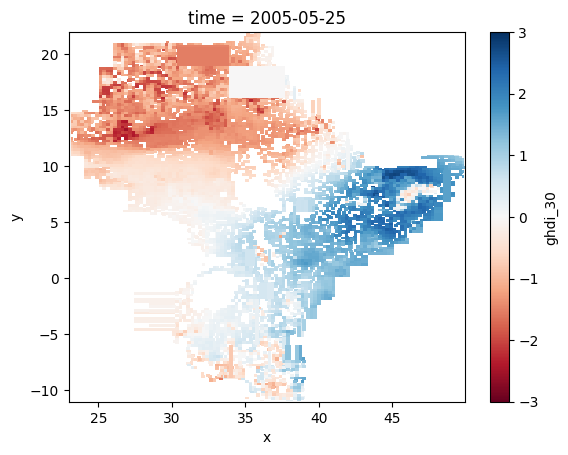

In [24]:
(combined_spi1).isel(time=48).plot(vmin=-3, cmap='RdBu')

In [16]:
y_full = np.arange(-11.0, 22.0, 0.05)
x_full = np.arange(23.0, 50.0, 0.05)

In [8]:
datasets_aligned = [
    ds.interp(y=y_full, x=x_full, method="nearest")
    for ds in datasets
]

ghdi_merged = datasets_aligned[0]["ghdi_30"].resample(time='ME').mean(dim='time')

# Fill gaps with other zones
for ds in datasets_aligned[1:]:
    ghdi_merged = ghdi_merged.fillna(ds["ghdi_30"].resample(time='ME').mean(dim='time'))

final_ds = ghdi_merged.to_dataset(name="ghdi_1")

In [117]:
remove_art(final_ds["ghdi_1"]).isel(time=147).plot(cmap='RdYlBu', vmin=-2, vmax=2)

NameError: name 'remove_art' is not defined

In [10]:
# Save to file
remove_art(final_ds).to_netcdf(os.path.join(dir, 'ghdi_full.nc'))

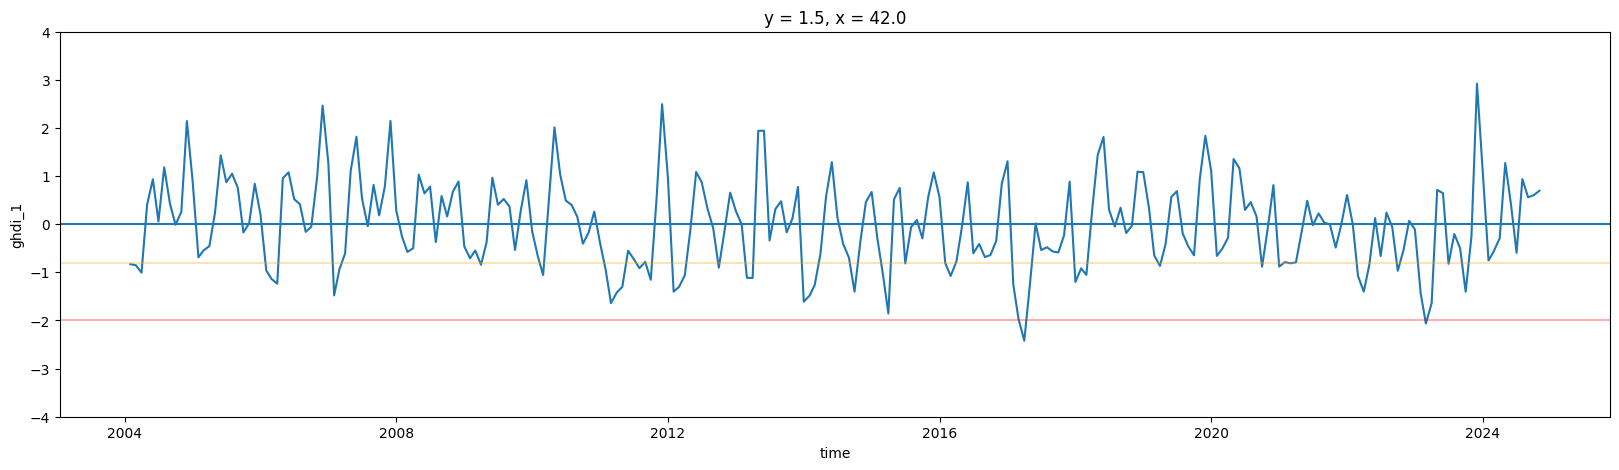

In [57]:
plt.figure(figsize=(20, 5))
final_ds["ghdi_1"].sel(y=1.5, x=42, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.8, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

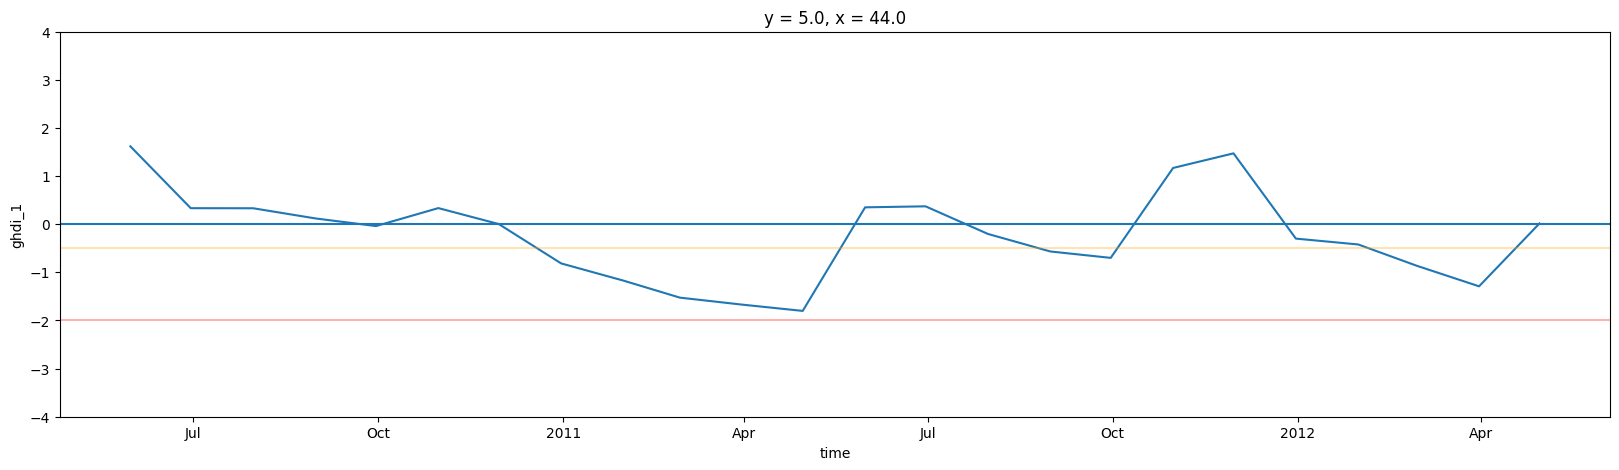

In [75]:
plt.figure(figsize=(20, 5))
final_ds["ghdi_1"].sel(time=slice('2010-05-01', '2012-05-01')).sel(y=5, x=44, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

In [112]:
march_index = final_one_month.isel(time=84).rio.write_crs("EPSG:4326")
march_index.rio.to_raster('2011_jan.tif')
# If you have multiple time slices (one per March), save each one:
# for t in march_index.time:
#     file_name = f"ghdi_march_{pd.to_datetime(t.values).strftime('%Y%m%d')}.tif"
#     march_index.sel(time=t).rio.to_raster(file_name)


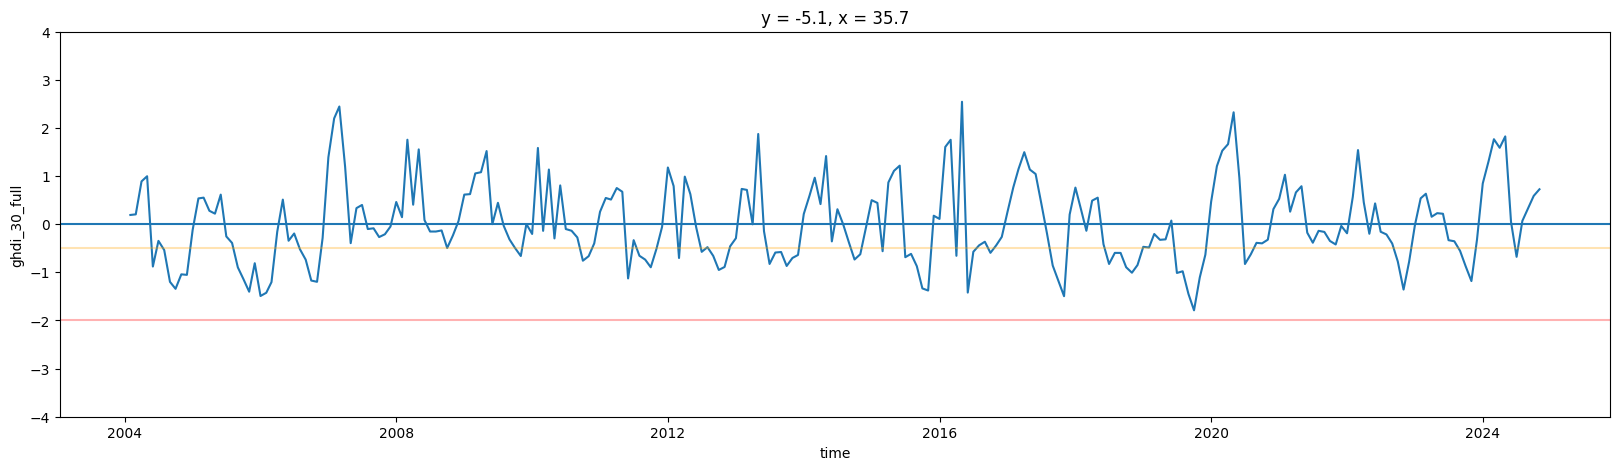

In [14]:
plt.figure(figsize=(20, 5))
final_one_month.sel(y=-5.1, x=35.72, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

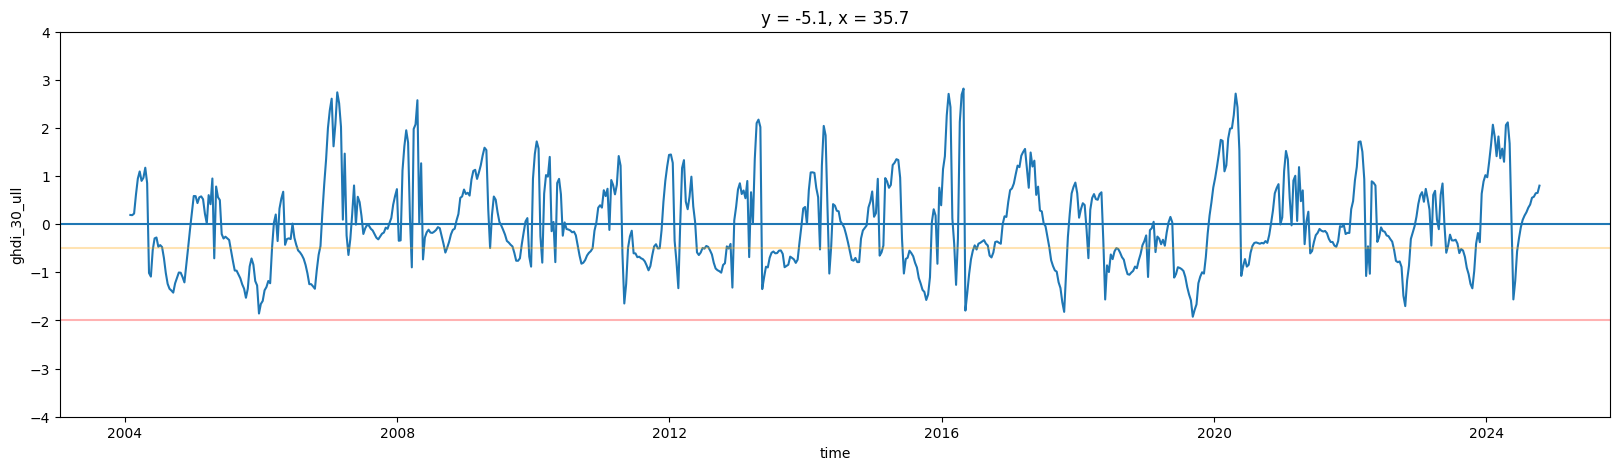

In [208]:
plt.figure(figsize=(20, 5))
final_ds["ghdi_30_ull"].sel(y=-5.1, x=35.72, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

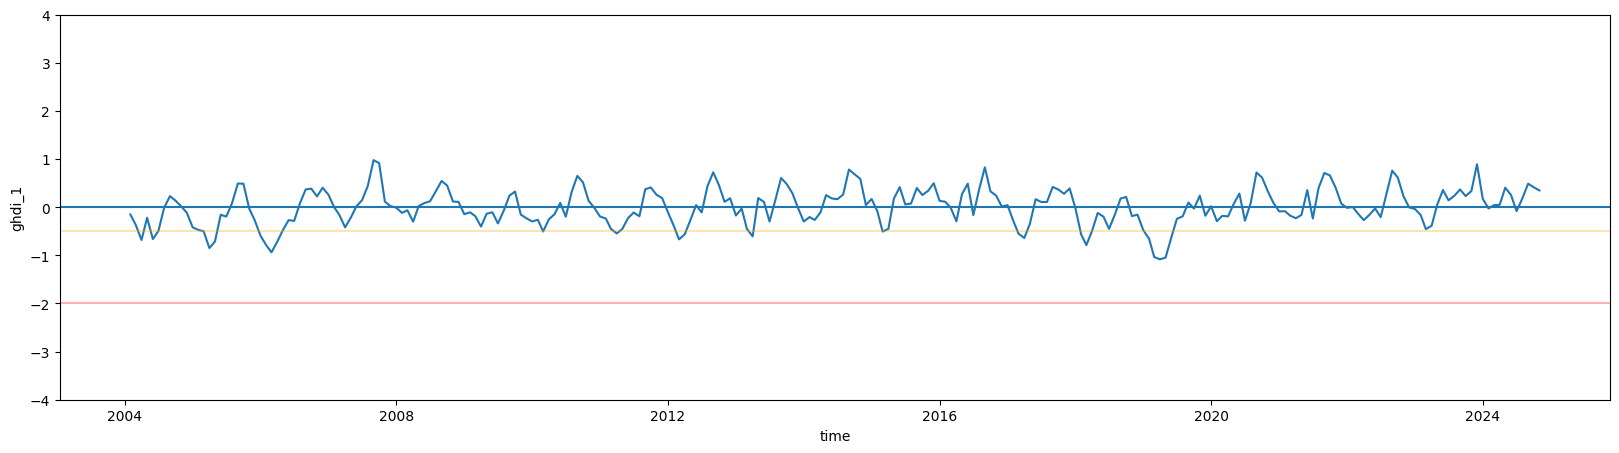

In [62]:
plt.figure(figsize=(20, 5))
final_ds["ghdi_1"].mean(['x', 'y']).plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

#### 90 day

In [11]:
ts_90_file = glob.glob("../../../datasets/drought_index/index_netcdf/ghdi_*_90.nc")
ts_90_file.sort()

In [12]:
# Load all datasets
ts_90 = [xr.open_dataset(file) for file in ts_90_file]

ts_90 = [ds.sortby(['x', 'y']) for ds in ts_90]

In [13]:
ts_90_aligned = [
    ds.interp(y=y_full, x=x_full, method="nearest")
    for ds in ts_90
]

ghdi_ts_90 = ts_90_aligned[0]["ghdi_90"].resample(time='ME').mean(dim='time')

# Fill gaps with other zones
for ds in ts_90_aligned[1:]:
    ghdi_ts_90 = ghdi_ts_90.fillna(ds["ghdi_90"].resample(time='ME').mean(dim='time'))

# Convert to Dataset
final_ds_90 = ghdi_ts_90.to_dataset(name="ghdi_3")

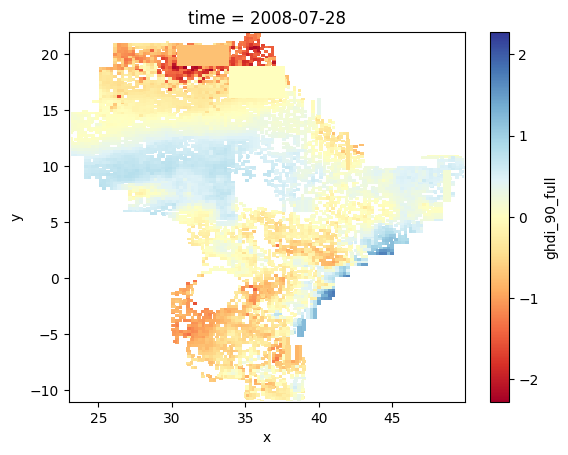

In [77]:
remove_art(final_ds_90.ghdi_90_full).isel(time=158).plot(cmap='RdYlBu')

In [14]:
# Save to file
remove_art(final_ds_90).to_netcdf(os.path.join(dir, 'ghdi_full_3m.nc'))

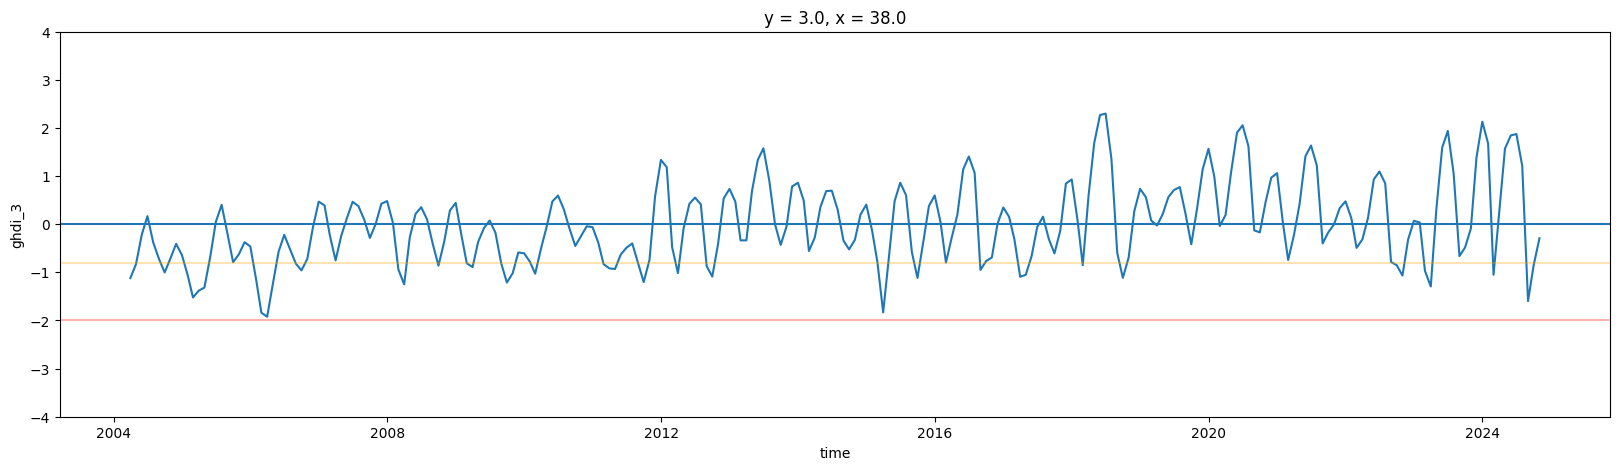

In [83]:
# Location 1

plt.figure(figsize=(20, 5))
final_ds_90["ghdi_3"].sel(y=3, x=38, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.8, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

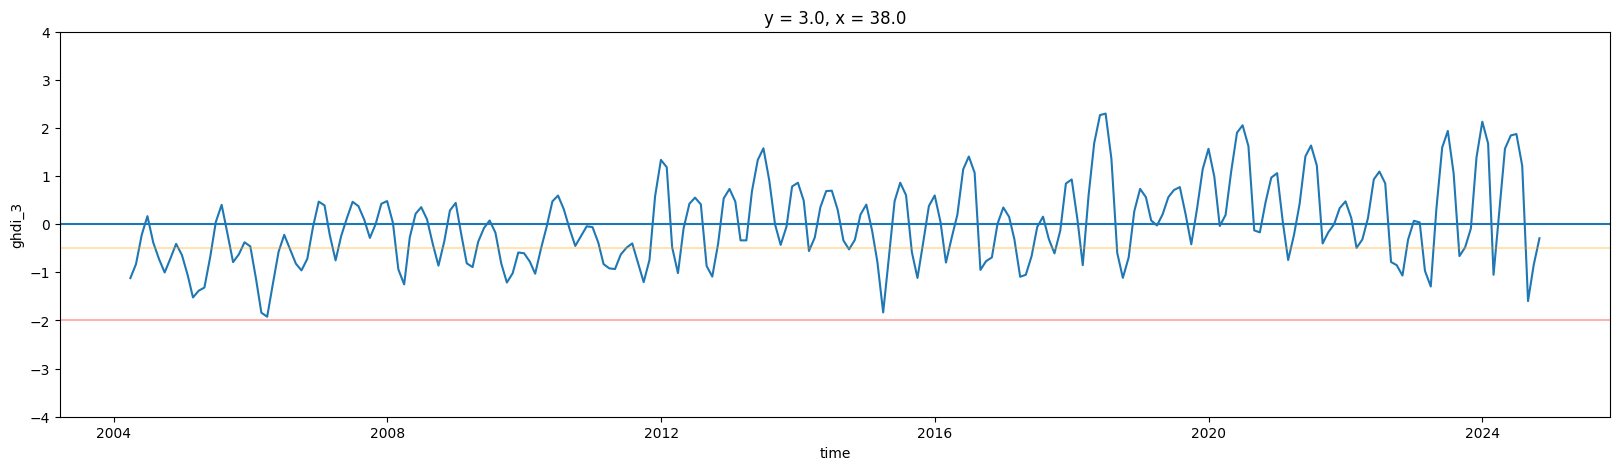

In [16]:
# Location 2

plt.figure(figsize=(20, 5))
final_ds_90["ghdi_3"].sel(y=3, x=38, method='nearest').plot()
plt.ylim(-, 4)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks = yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as 'YYYY'
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

In [ ]:
plt.figure(figsize=(20, 5))
final_ds_90["ghdi_90_full"].sel(time=slice('2010-05-01', '2012-05-01')).sel(y=1, x=42, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

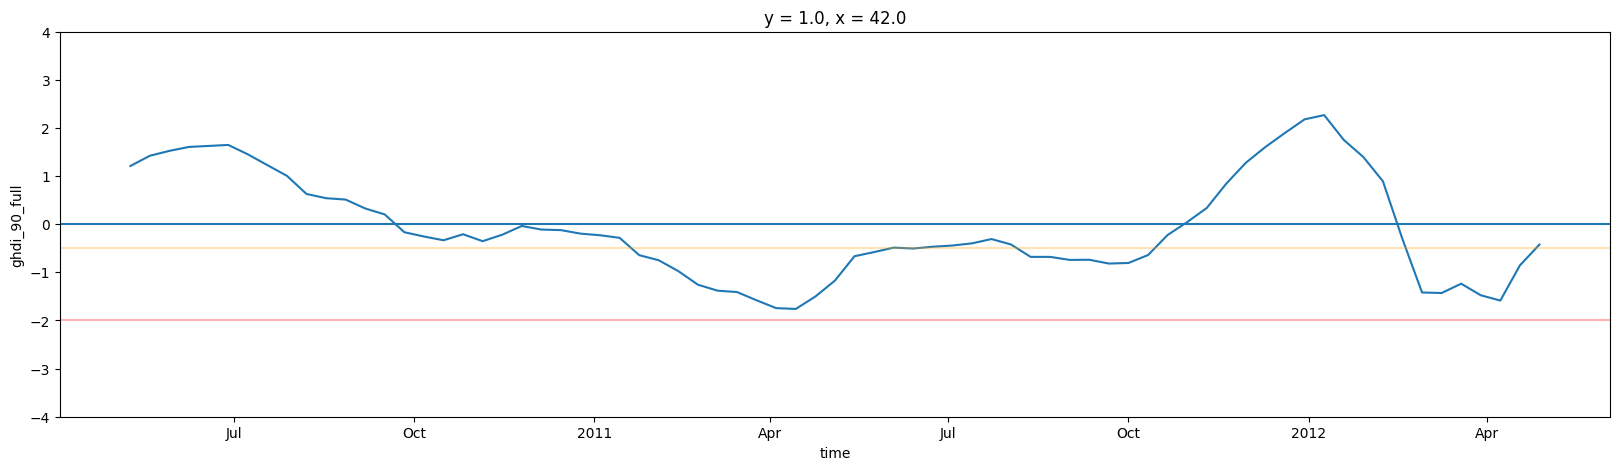

In [71]:
plt.figure(figsize=(20, 5))
final_ds_90["ghdi_90_full"].sel(time=slice('2010-05-01', '2012-05-01')).sel(y=1, x=42, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

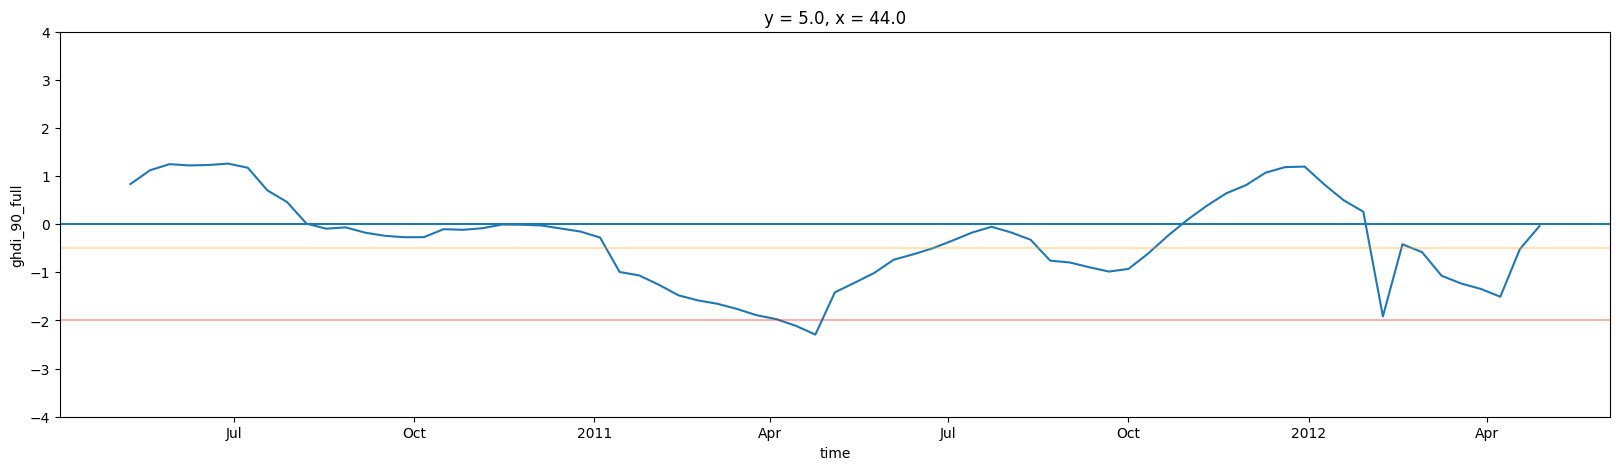

In [74]:
plt.figure(figsize=(20, 5))
final_ds_90["ghdi_90_full"].sel(time=slice('2010-05-01', '2012-05-01')).sel(y=5, x=44, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

#### 180 day

In [5]:
ts_180_file = glob.glob("../../../datasets/drought_index/index_netcdf/ghdi_*_180.nc")
ts_180_file.sort()

In [6]:
# Load all datasets
ts_180 = [xr.open_dataset(file) for file in ts_180_file]

ts_180 = [ds.sortby(['x', 'y']) for ds in ts_180]

ts_180_aligned = [
    ds.interp(y=y_full, x=x_full, method="nearest")
    for ds in ts_180
]

ghdi_ts_180 = ts_180_aligned[0]["ghdi_180"].resample(time='ME').mean(dim='time')

# Fill gaps with other zones
for ds in ts_180_aligned[1:]:
    ghdi_ts_180 = ghdi_ts_180.fillna(ds["ghdi_180"].resample(time='ME').mean(dim='time'))

# Convert to Dataset
final_ts_180 = ghdi_ts_180.to_dataset(name="ghdi_6")

In [38]:
final_nine_month = final_ts_180["ghdi_180_full"].resample(time='M').mean(dim='time')

/home/jovyan/gh/pyghdi/lib/python3.11/site-packages/xarray/groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


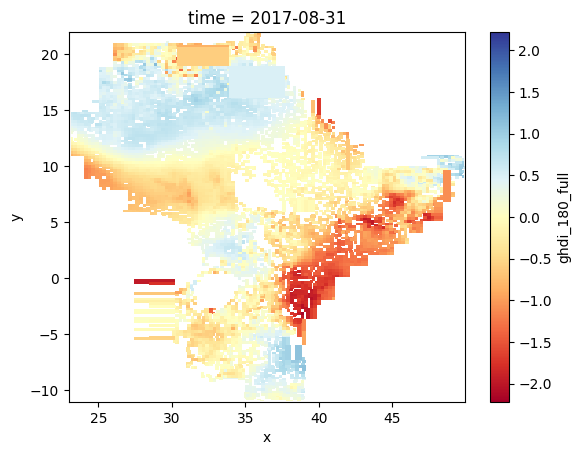

In [28]:
final_nine_month.isel(time=158).plot(cmap='RdYlBu')

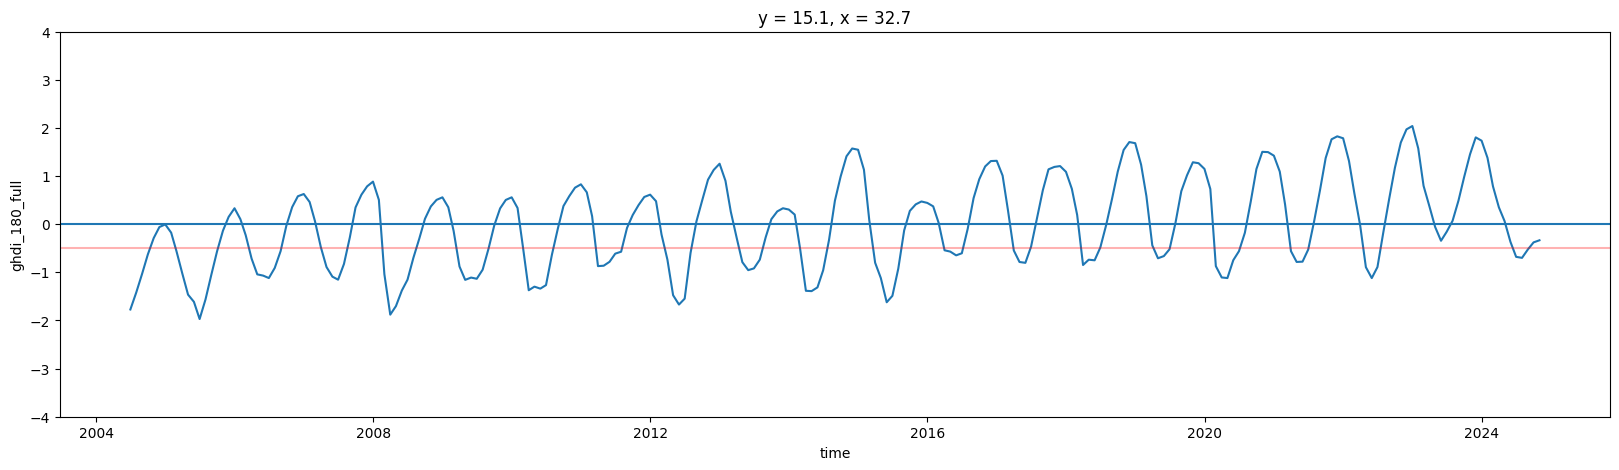

In [34]:
plt.figure(figsize=(20, 5))
final_nine_month.sel(y=15.1, x=32.72, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='red', alpha=0.3)
# plt.axhline(-2, color='red', alpha=0.3)

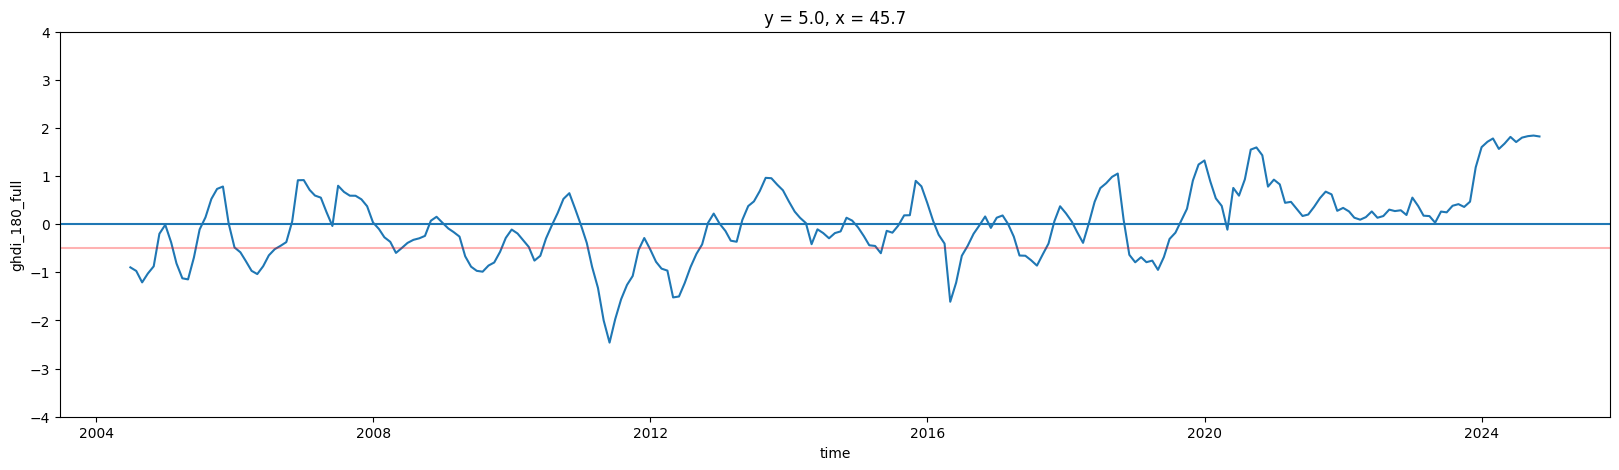

In [38]:
plt.figure(figsize=(20, 5))
final_nine_month.sel(y=5, x=45.72, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='red', alpha=0.3)
# plt.axhline(-2, color='red', alpha=0.3)

In [7]:
remove_art(final_ts_180).to_netcdf(os.path.join(dir, 'ghdi_full_6m.nc'))

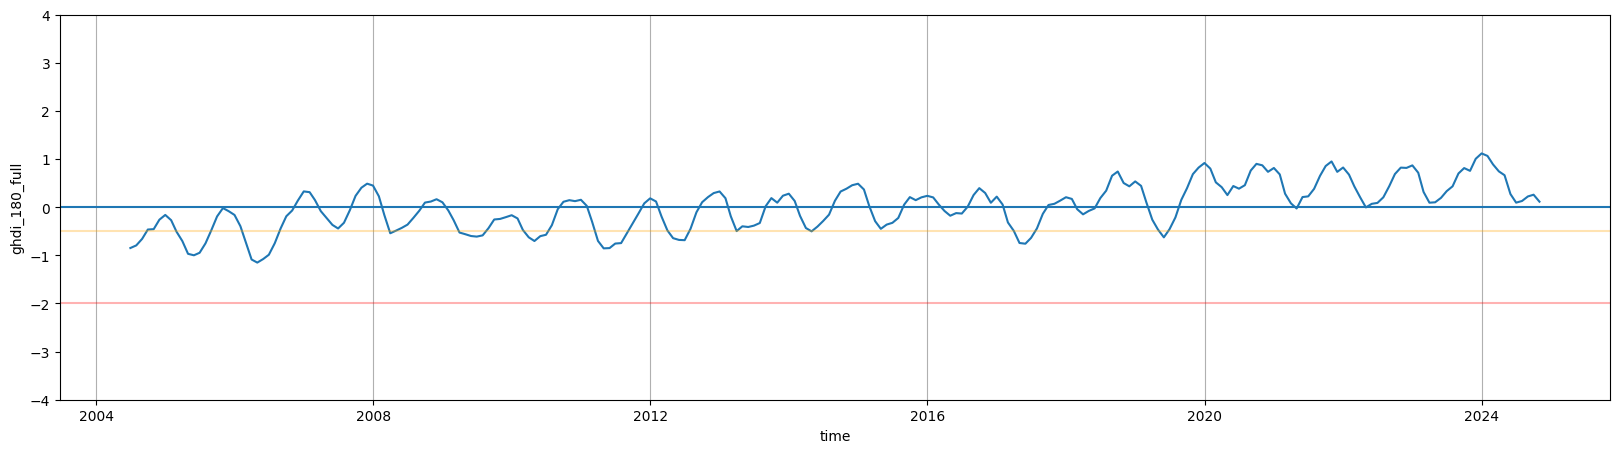

In [39]:
plt.figure(figsize=(20, 5))
final_nine_month.mean(['x', 'y']).plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)
plt.grid(which='major', axis='x')

#### 360 day

In [10]:
ts_360_file =  glob.glob("../../../datasets/drought_index/index_netcdf/ghdi_*_360.nc")
ts_360_file.sort()

In [11]:
# Load all datasets
ts_360 = [xr.open_dataset(file) for file in ts_360_file]

# Sort coordinates to ensure monotonicity within each dataset
ts_360 = [ds.sortby(['x', 'y']) for ds in ts_360]


In [10]:
ts_360_aligned = [
    ds.interp(y=y_full, x=x_full, method="nearest")
    for ds in ts_360
]

In [11]:
# Initialize with Zone 1
ghdi_ts_360 = ts_360_aligned[0]["ghdi_360"].resample(time='ME').mean(dim='time')

# Fill gaps with other zones
for ds in ts_360_aligned[1:]:
    ghdi_ts_360 = ghdi_ts_360.fillna(ds["ghdi_360"].resample(time='ME').mean(dim='time'))

# Convert to Dataset
final_ts_360 = ghdi_ts_360.to_dataset(name="ghdi_12")

In [12]:
final_ts_360 = final_ts_360["ghdi_12"].resample(time='M').mean(dim='time')

/home/jovyan/gh/pyghdi/lib/python3.11/site-packages/xarray/groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [12]:
ts_360[4]

<xarray.Dataset> Size: 84MB
Dimensions:         (time: 724, y: 104, x: 70)
Coordinates:
  * time            (time) datetime64[ns] 6kB 2004-12-26 ... 2024-10-12
  * y               (y) float64 832B -10.78 -10.53 -9.725 ... 15.27 16.07 16.32
  * x               (x) float64 560B 23.58 23.83 24.08 ... 48.03 48.28 48.63
    ghdi_360        (time, y, x) float64 42MB ...
Data variables:
    GHDIPlains_360  (time, y, x) float64 42MB ...

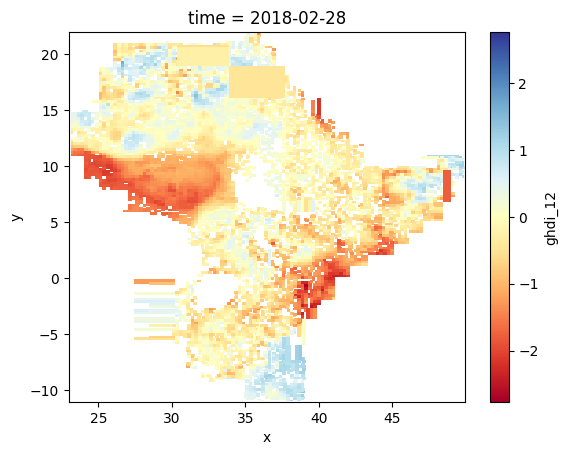

In [15]:
final_ts_360.isel(time=158).plot(cmap='RdYlBu')

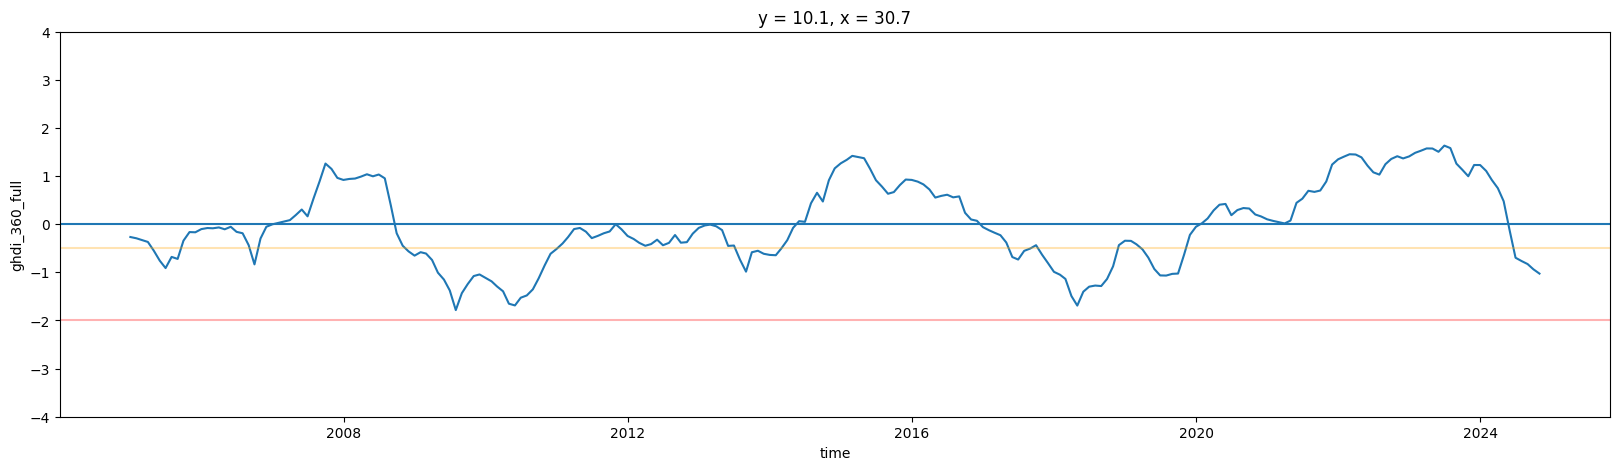

In [63]:
plt.figure(figsize=(20, 5))
final_twelve_month.sel(y=10.1, x=30.72, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

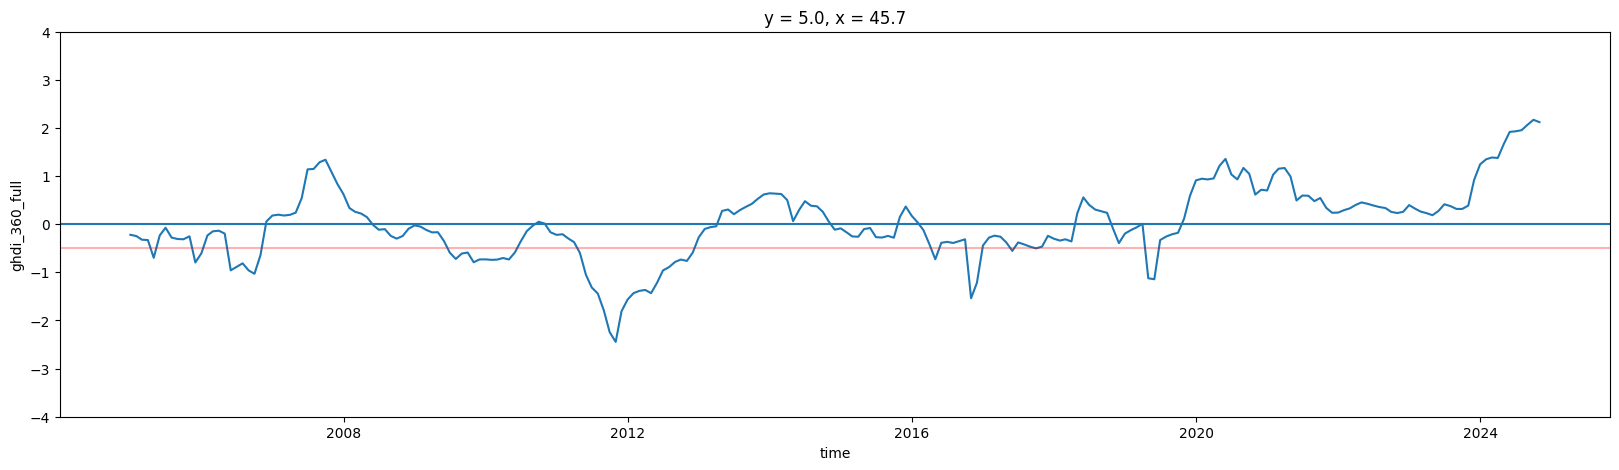

In [48]:
plt.figure(figsize=(20, 5))
final_twelve_month.sel(y=5, x=45.72, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='red', alpha=0.3)
# plt.axhline(-2, color='red', alpha=0.3)

In [53]:
remove_art(final_ts_360).to_netcdf(os.path.join(dir, 'ghdi_full_12m.nc'))

### Temporal Pattern

In [25]:
index_nc = glob.glob("../../../datasets/drought_index/ghdi_full_*.nc")
# index_nc.sort()

In [27]:
np.sort(index_nc)

array(['../../../datasets/drought_index/ghdi_full_12m.nc',
       '../../../datasets/drought_index/ghdi_full_1m.nc',
       '../../../datasets/drought_index/ghdi_full_3m.nc',
       '../../../datasets/drought_index/ghdi_full_6m.nc'], dtype='<U48')

In [4]:
drough_index = [xr.open_dataset(ds) for ds in index_nc]

In [83]:
# locations

plains = {
    
    'kenya' : [],
    'somalia' : [5.7, 47],
    'Ethopia' : []

}

mid_alt = {
    
    'kenya' : [1.92, 39.82],
    'somalia' : [],
    'Ethopia' : []

}

high_alt = {
    
    'kenya' : [],
    'somalia' : [],
    'ethiopia' : [7.30, 41]

}

In [ ]:
ts_plot(lat, lon):
    plotter = 

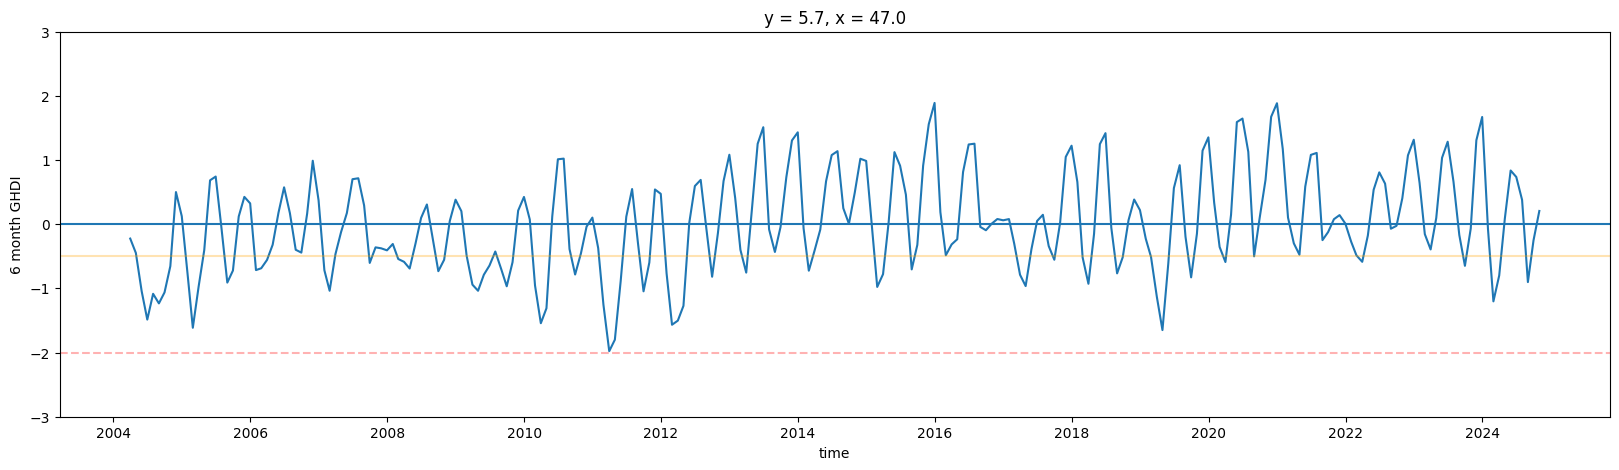

In [68]:
# Location 1

plt.figure(figsize=(20, 5))
drough_index[0]["ghdi_3"].sel(y=plains['somalia'][0], x=plains['somalia'][1], method='nearest').plot()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks = yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim(-3, 3)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3, linestyle='--')
plt.ylabel('6 month GHDI')
plt.show()

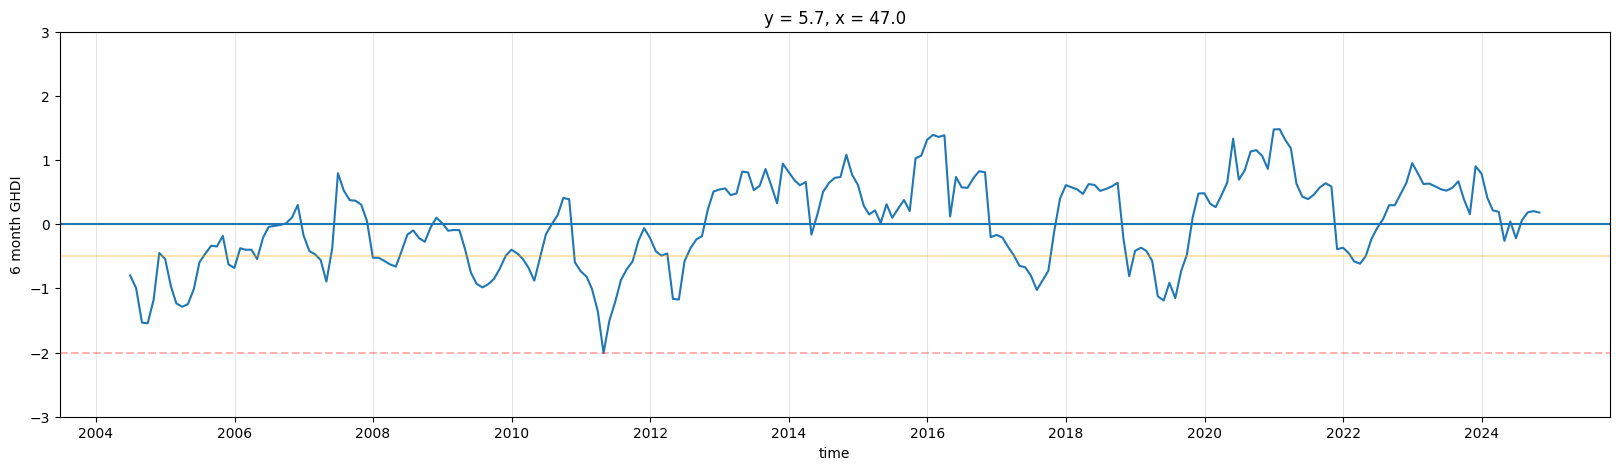

In [76]:
# Location 1

plt.figure(figsize=(20, 5))
drough_index[1]["ghdi_6"].sel(y=plains['somalia'][0], x=plains['somalia'][1], method='nearest').plot()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks = yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim(-3, 3)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3, linestyle='--')
plt.ylabel('6 month GHDI')
plt.grid(axis='x', alpha=.3)
plt.show()

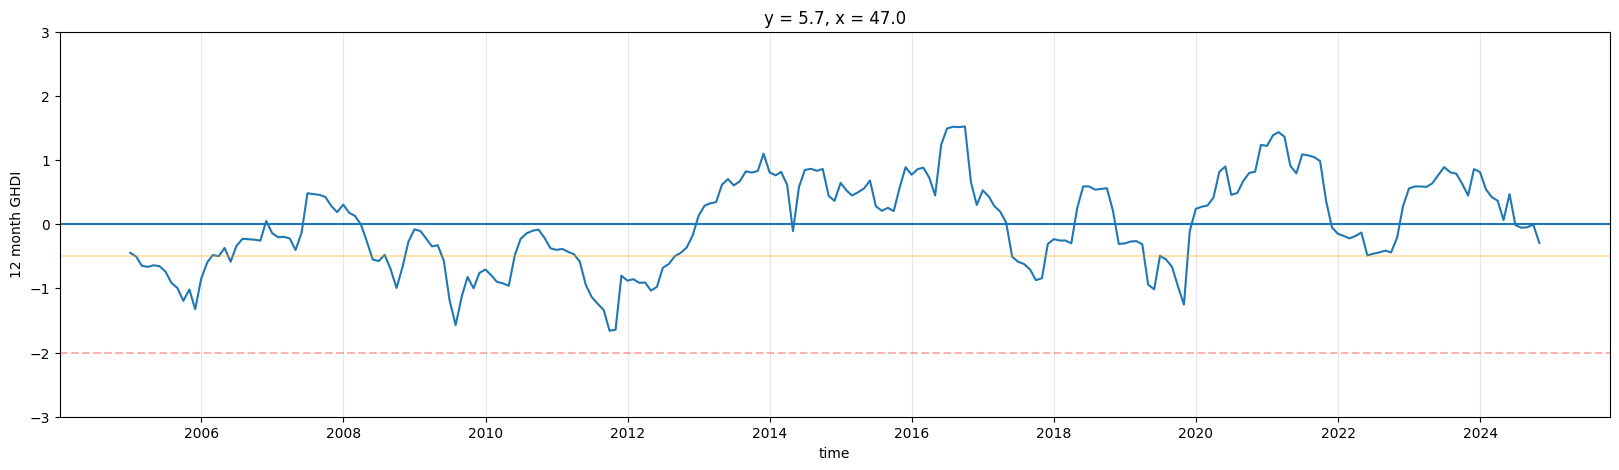

In [87]:
# Location 1

plt.figure(figsize=(20, 5))
drough_index[2]["ghdi_12"].sel(y=plains['somalia'][0], x=plains['somalia'][1], method='nearest').plot()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks = yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim(-3, 3)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3, linestyle='--')
plt.ylabel('12 month GHDI')
plt.grid(axis='x', alpha=.3)
plt.show()

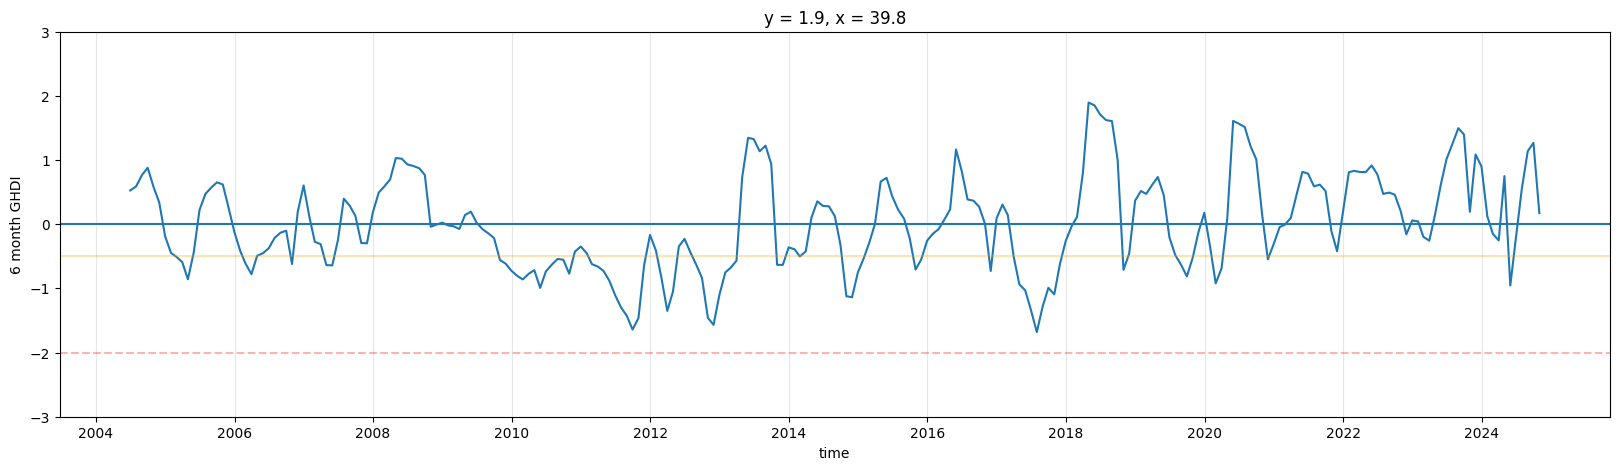

In [88]:
# Location 2

plt.figure(figsize=(20, 5))
drough_index[1]["ghdi_6"].sel(y=mid_alt['kenya'][0], x=mid_alt['kenya'][1], method='nearest').plot()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks = yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim(-3, 3)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3, linestyle='--')
plt.ylabel('6 month GHDI')
plt.grid(axis='x', alpha=.3)
plt.show()


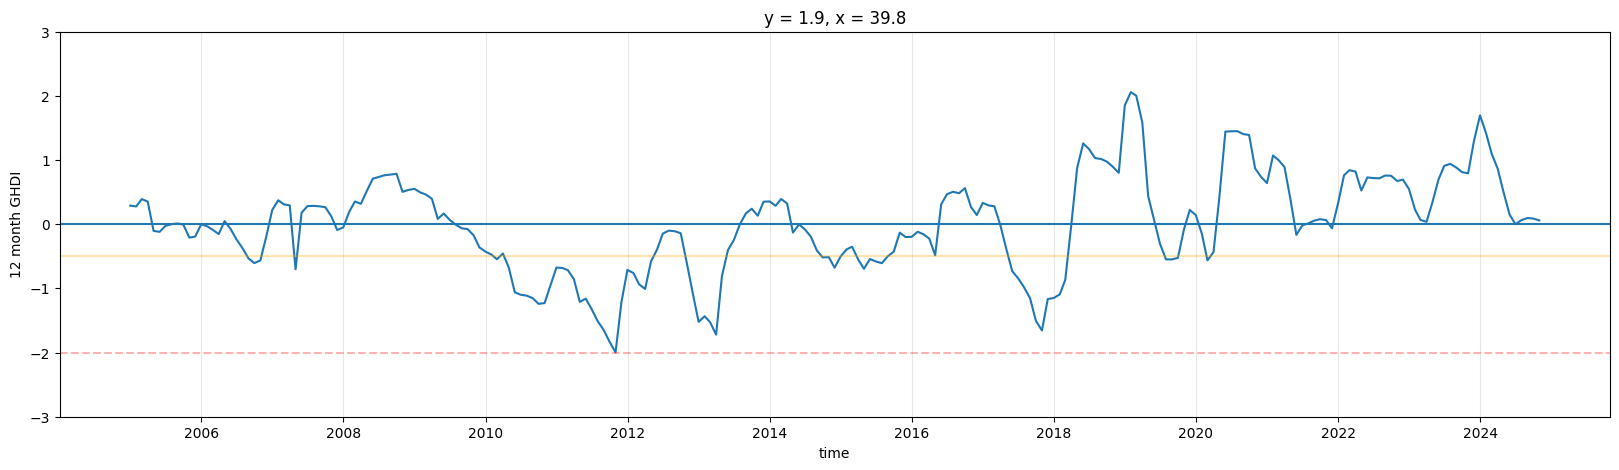

In [89]:
plt.figure(figsize=(20, 5))
drough_index[2]["ghdi_12"].sel(y=mid_alt['kenya'][0], x=mid_alt['kenya'][1], method='nearest').plot()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks = yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim(-3, 3)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3, linestyle='--')
plt.ylabel('12 month GHDI')
plt.grid(axis='x', alpha=.3)
plt.show()

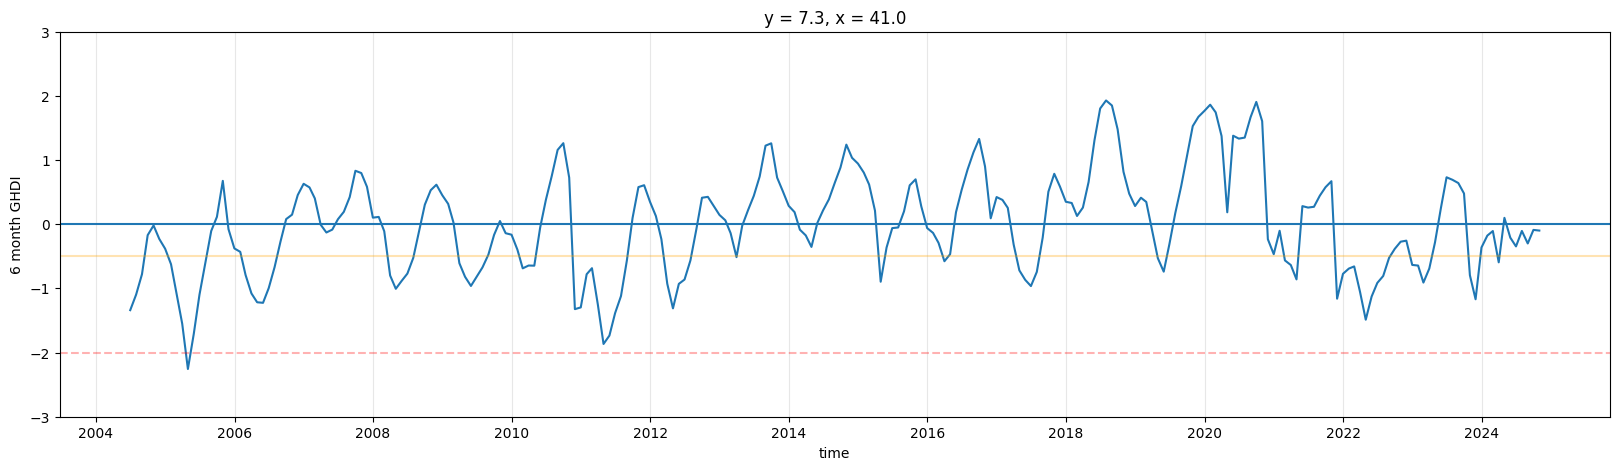

In [90]:
# Location 2

plt.figure(figsize=(20, 5))
drough_index[1]["ghdi_6"].sel(y=high_alt['ethiopia'][0], x=high_alt['ethiopia'][1], method='nearest').plot()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim(-3, 3)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3, linestyle='--')
plt.ylabel('6 month GHDI')
plt.grid(axis='x', alpha=.3)
plt.show()

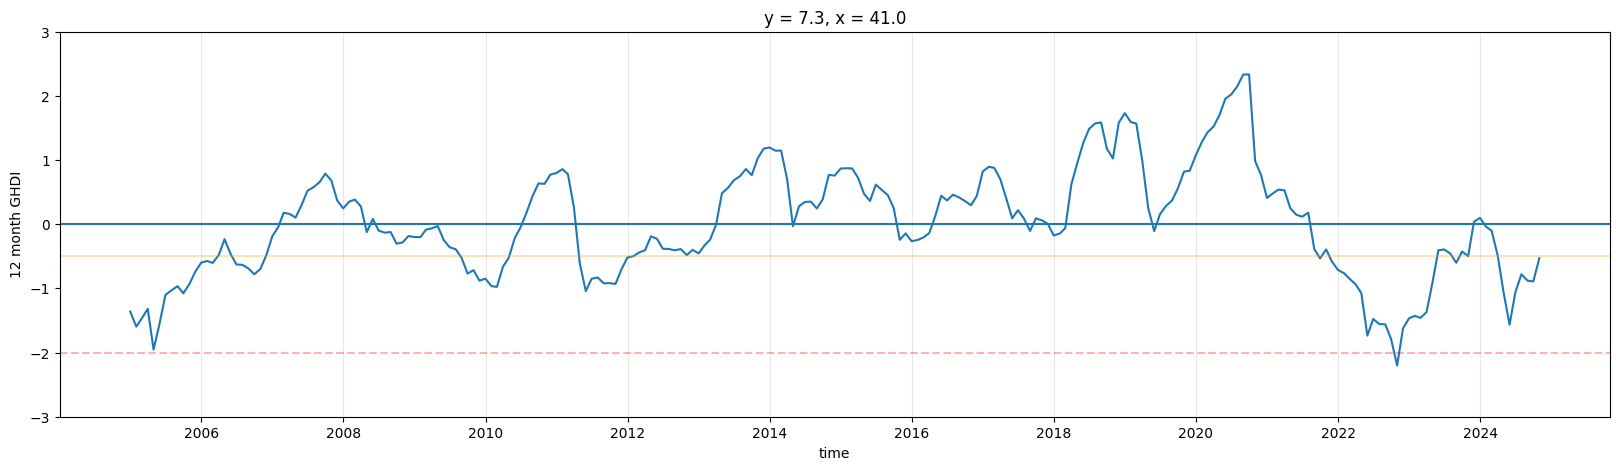

In [91]:
plt.figure(figsize=(20, 5))
drough_index[2]["ghdi_12"].sel(y=high_alt['ethiopia'][0], x=high_alt['ethiopia'][1], method='nearest').plot()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim(-3, 3)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3, linestyle='--')
plt.ylabel('12 month GHDI')
plt.grid(axis='x', alpha=.3)
plt.show()

#### Box plots

In [11]:
ghdi_list = [
    ('30', ghdi_30.ghdi_1),
    ('90', ghdi_90.ghdi_3),
    ('180', ghdi_180.ghdi_6),
    ('360', ghdi_360.ghdi_12)
]

# Extract flattened valid data for each timescale
box_data = []
labels = []

for label, da in ghdi_list:
    # Flatten and remove NaNs
    values = da.values.flatten()
    values = values[~np.isnan(values)]
    
    box_data.append(values)
    labels.append(label)


/tmp/ipykernel_197/1394565701.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels, patch_artist=True)


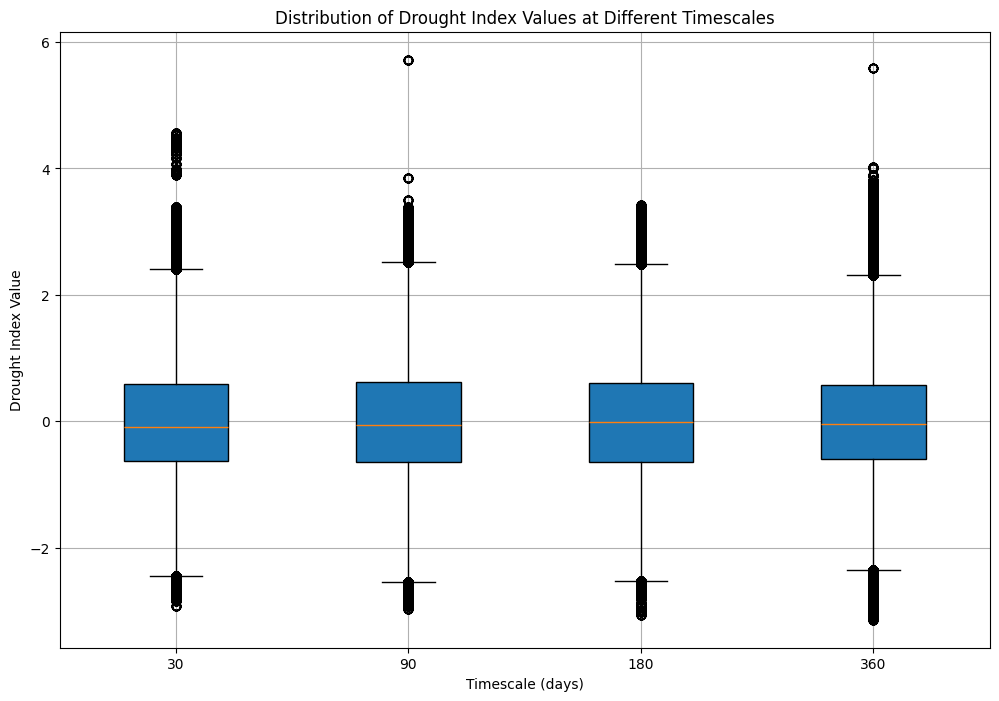

In [12]:
plt.figure(figsize=(12, 8))
plt.boxplot(box_data, labels=labels, patch_artist=True)
plt.xlabel('Timescale (days)')
plt.ylabel('Drought Index Value')
plt.title('Distribution of Drought Index Values at Different Timescales')
plt.grid(True)
plt.show()

/tmp/ipykernel_197/2758379910.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels, patch_artist=True,


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff7db03f1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff7da9d4590>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7ff7db14a390>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff7da7a8410>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff7dad93bd0>,
 'means': []}

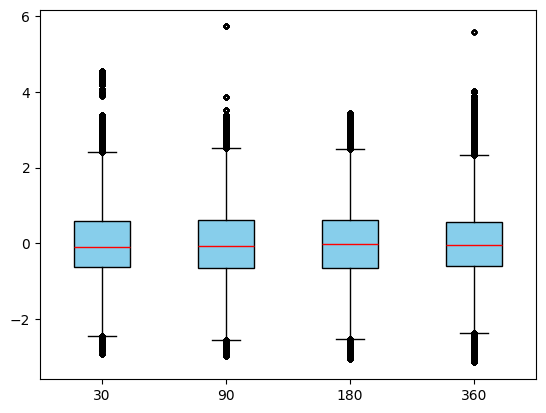

In [13]:
plt.boxplot(box_data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', color='black', markersize=3))


In [231]:
q_global = [0.02, 0.05, 0.10, 0.20, 0.30] # 2nd, 5th, 10th, 20th, 30th percentiles
global_percentiles = g36.quantile(q=q_global, dim=None) # dim=None calculates over all dimensions
print("\nGlobal Percentiles (across all data):\n", global_percentiles)


Global Percentiles (across all data):
 <xarray.DataArray 'ghdi_360_ull' (quantile: 5)> Size: 40B
array([-1.72549637, -1.40541249, -1.10101682, -0.73830353, -0.48069669])
Coordinates:
  * quantile  (quantile) float64 40B 0.02 0.05 0.1 0.2 0.3


#### Spatial Evolution of drought

In [29]:
ghdi_30 = xr.open_dataset(os.path.join(dir, 'ghdi_full_1m.nc'))
ghdi_90 = xr.open_dataset(os.path.join(dir, 'ghdi_full_3m.nc'))
ghdi_180 = xr.open_dataset(os.path.join(dir, 'ghdi_full_6m.nc'))
ghdi_360 = xr.open_dataset(os.path.join(dir, 'ghdi_full_12m.nc'))

In [67]:
# Define the months you're interested in
# months = ['2010-10', '2010-11', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01']

months = ['2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01']

# Extract for each month
selected_1m = ghdi_30.ghdi_1.sel(time=months, method='nearest')
selected_3m = ghdi_90.ghdi_3.sel(time=months, method='nearest')
selected_9m = ghdi_180.ghdi_6.sel(time=months, method='nearest')
selected_12m = ghdi_360.ghdi_12.sel(time=months, method='nearest')


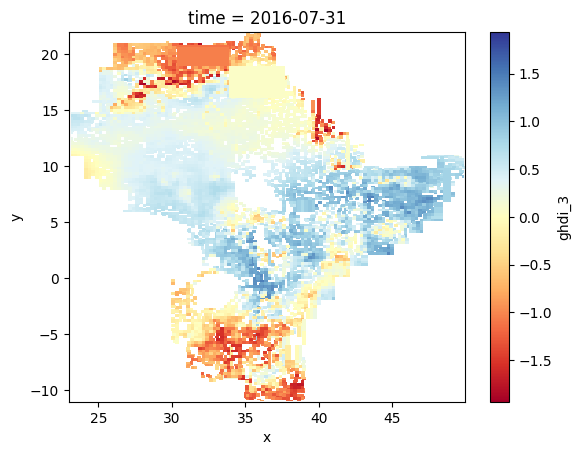

In [122]:
ghdi_90.ghdi_3.isel(time=148).plot(cmap='RdYlBu')

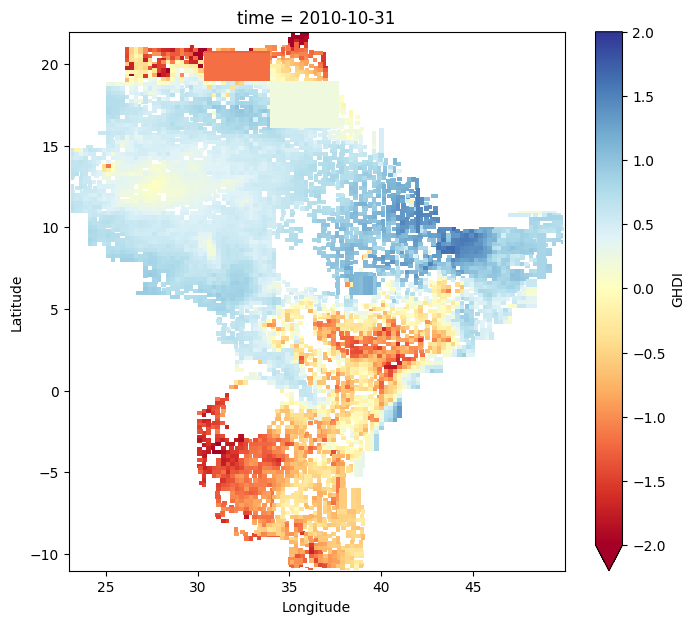

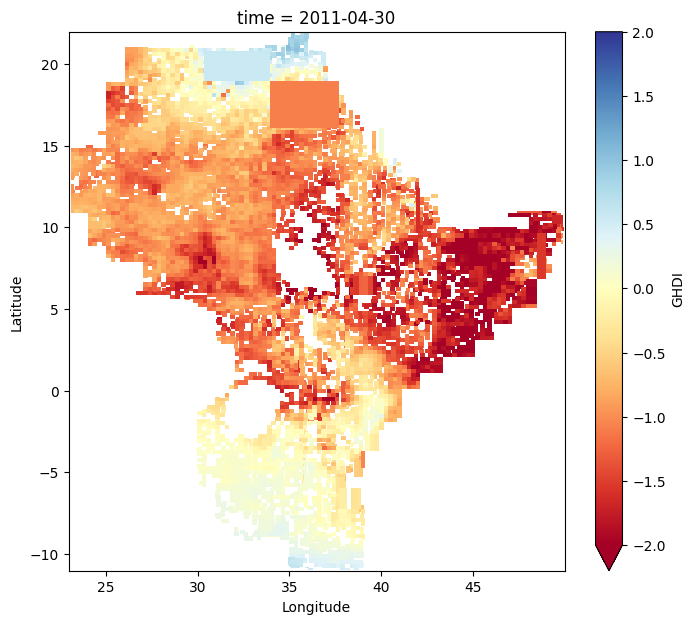

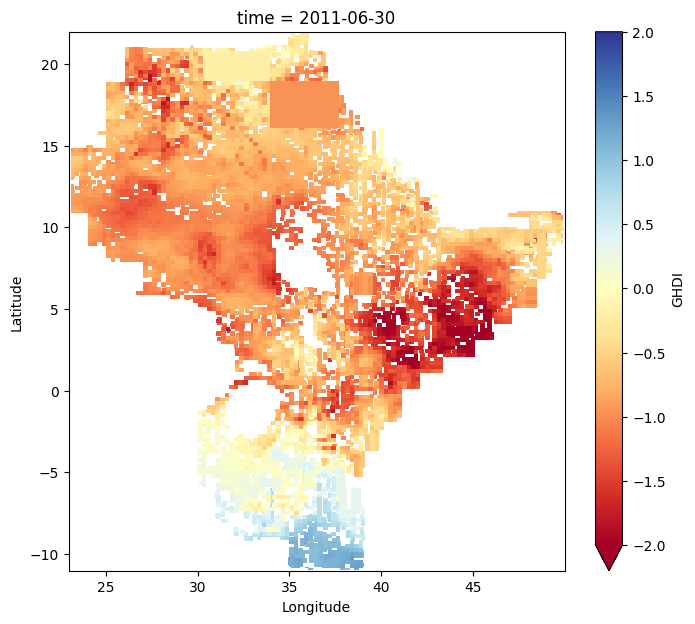

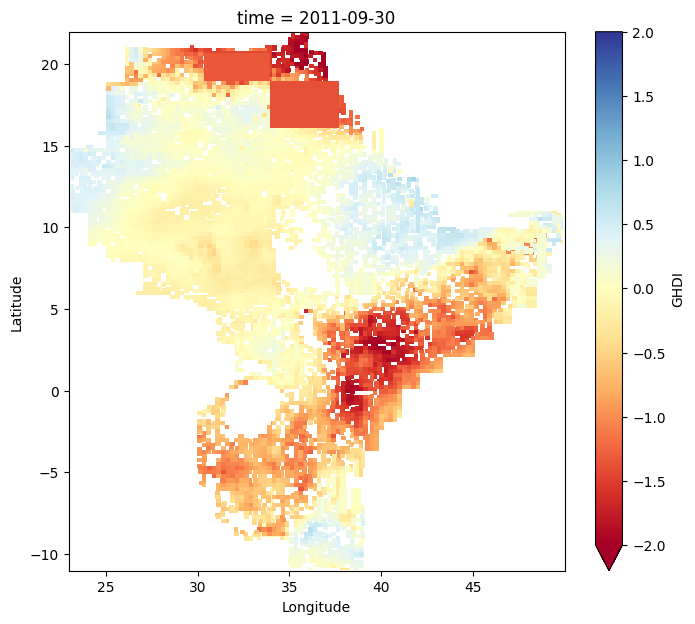

In [118]:
import matplotlib.pyplot as plt

def plot_ghdi(data, month, timescale):
    plt.figure(figsize=(8, 7))
    data.plot(cmap='RdYlBu', cbar_kwargs={'label': 'GHDI'}, vmin=-2, vmax=2)
    # plt.title(f'{timescale}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Loop through the selected months
for i, month in enumerate(months):
    # plot_ghdi(selected_3m.isel(time=i), month, '3-Month GHDI')
    plot_ghdi(selected_9m.isel(time=i), month, '9-Month GHDI')
    # plot_ghdi(selected_12m.isel(time=i), month, '12-Month GHDI')


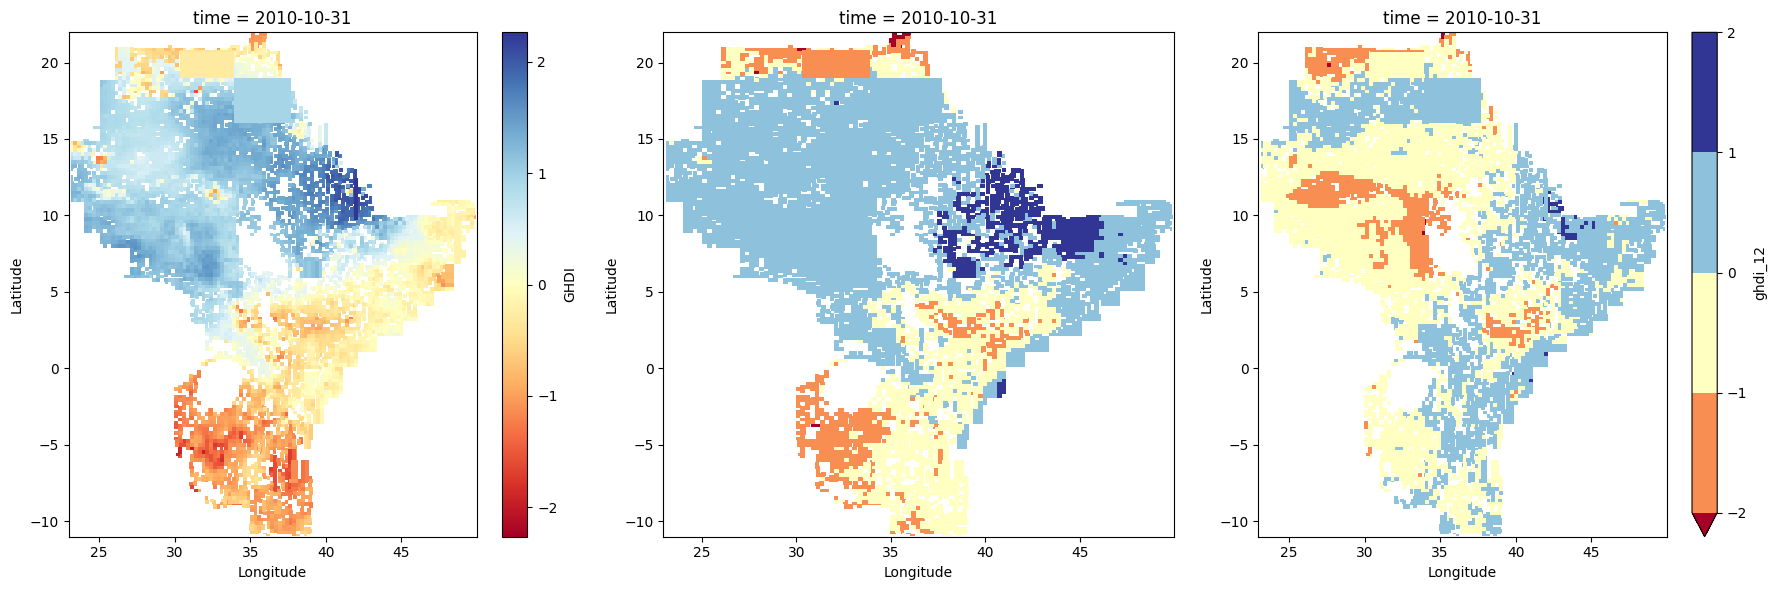

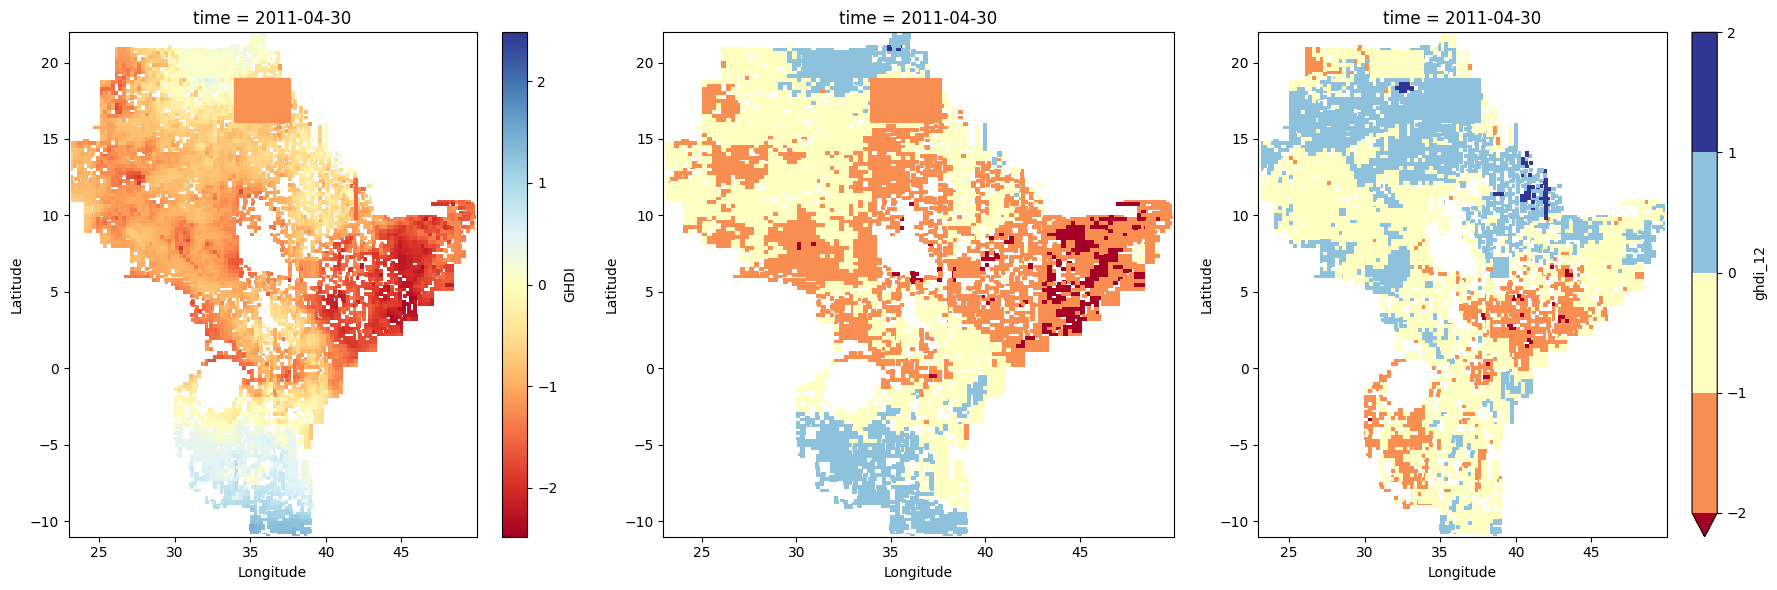

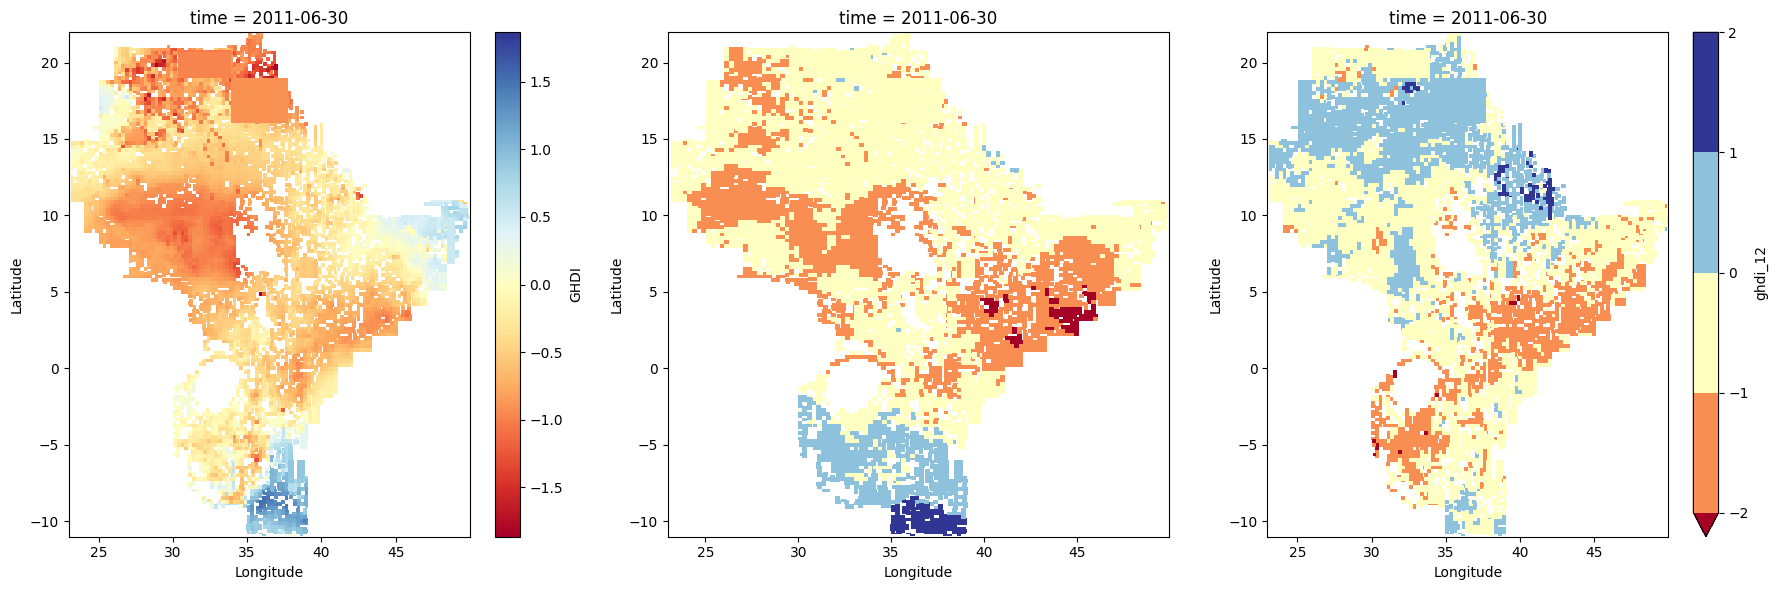

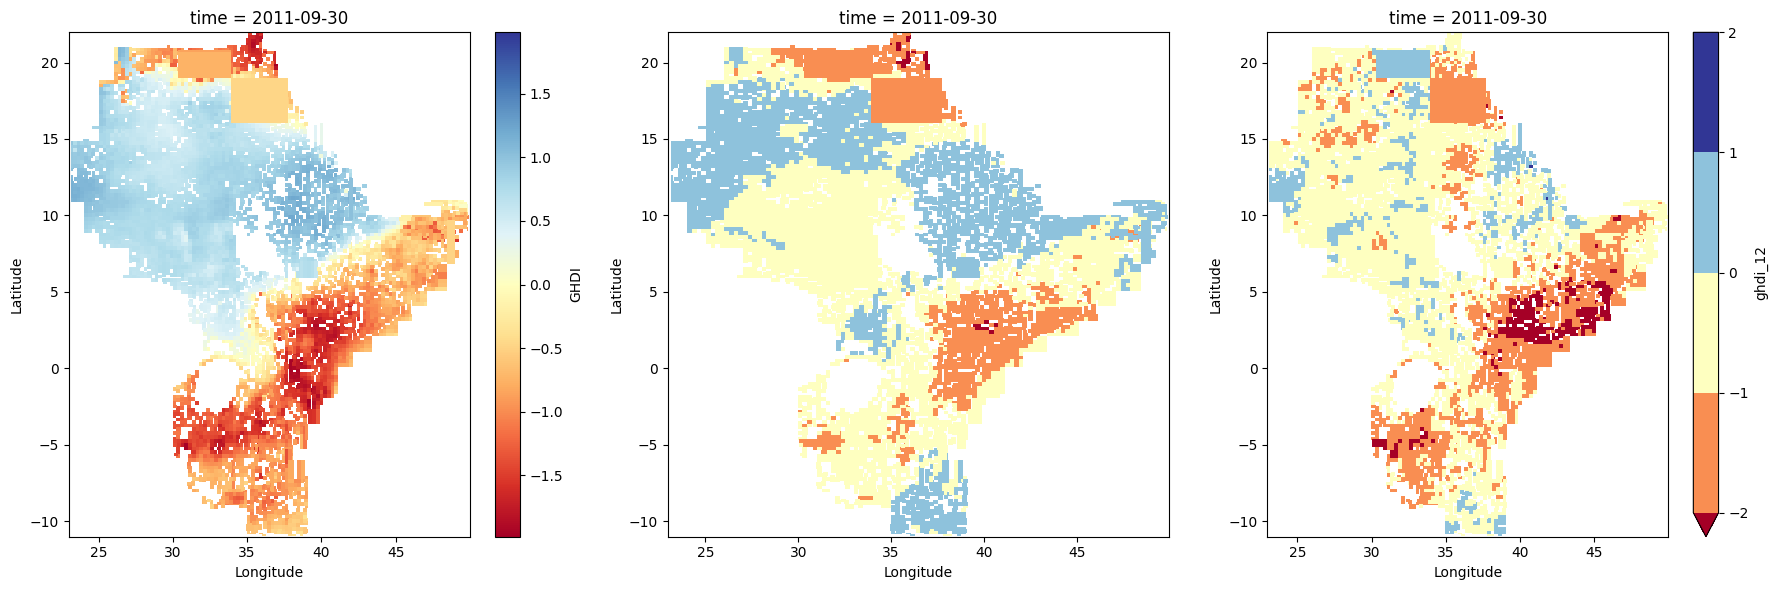

In [114]:
import matplotlib.pyplot as plt

# Define the months
months = ['2010-11', '2011-05', '2011-07', '2011-10']

# Extract data for each timescale
selected_3m = ghdi_90.ghdi_3.sel(time=months, method='nearest')
selected_9m = ghdi_180.ghdi_6.sel(time=months, method='nearest')
selected_12m = ghdi_360.ghdi_12.sel(time=months, method='nearest')

# Define drought severity thresholds (adjust as needed)
thresholds = [-2, -1, 0, 1, 2]  # You can customize these

# Function to plot subplots for each month
def plot_monthly_subplots(month_idx, month):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 3-Month
    selected_3m.isel(time=month_idx).plot(ax=axes[0], cmap='RdYlBu',
                                          cbar_kwargs={'label': 'GHDI'})
    # axes[0].set_title(f'3-Month GHDI - {month}')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')


    # Plot 9-Month
    selected_9m.isel(time=month_idx).plot(ax=axes[1], cmap='RdYlBu', levels=thresholds,
                                          add_colorbar=False)
    # axes[1].set_title(f'9-Month GHDI - {month}')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')


    # Plot 12-Month
    selected_12m.isel(time=month_idx).plot(ax=axes[2], cmap='RdYlBu', levels=thresholds,
                                           )
    # axes[2].set_title(f'12-Month GHDI - {month}')
    axes[2].set_xlabel('Longitude')
    axes[2].set_ylabel('Latitude')


    plt.tight_layout()
    plt.show()

# Loop through months
for idx, month in enumerate(months):
    plot_monthly_subplots(idx, month)


In [99]:
selected_3m

<xarray.DataArray 'ghdi_3' (time: 4, y: 660, x: 540)> Size: 11MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], shape=(4, 660, 540))
Coordinates:
  * y        (y) float64 5kB -11.0 -10.95 -10.9 -10.85 ... 21.8 21.85 21.9 21.95
  * x        (x) float64 4kB 23.0 23.05 23.1 23.15 ... 49.8 49.85 49.9 49.95
  * time     (time) datetime64[ns] 32B 2010-10-31 2011-04-30 ... 2011-09-30

In [115]:
selected_9m

<xarray.DataArray 'ghdi_6' (time: 4, y: 660, x: 540)> Size: 11MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], shape=(4, 660, 540))
Coordinates:
  * y        (y) float64 5kB -11.0 -10.95 -10.9 -10.85 ... 21.8 21.85 21.9 21.95
  * x        (x) float64 4kB 23.0 23.05 23.1 23.15 ... 49.8 49.85 49.9 49.95
  * time     (time) datetime64[ns] 32B 2010-10-31 2011-04-30 ... 2011-09-30

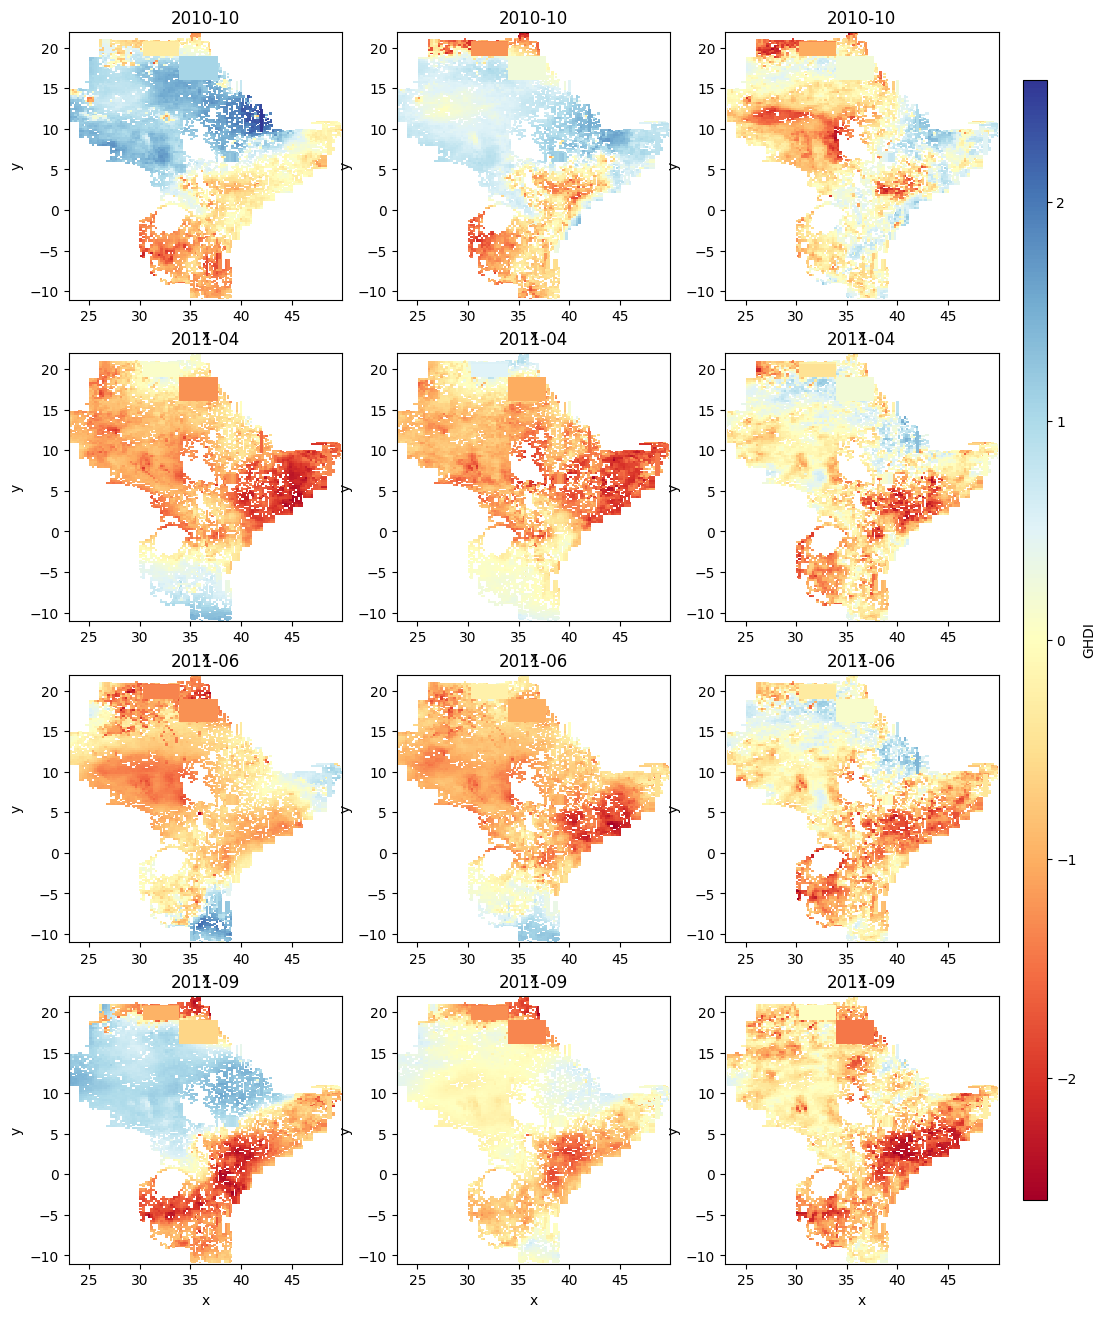

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Define the months
months = ['2010-11', '2011-05', '2011-07', '2011-10']


# Convert strings to datetime for matching
target_dates = pd.to_datetime(months)

# Find nearest dates in your dataset
available_dates = ghdi_90.time.values
nearest_dates = [available_dates[(abs(available_dates - np.datetime64(target))).argmin()] for target in target_dates]

# Extract data for each timescale
selected_3m = ghdi_90.ghdi_3.sel(time=nearest_dates)
selected_9m = ghdi_180.ghdi_6.sel(time=nearest_dates)
selected_12m = ghdi_360.ghdi_12.sel(time=nearest_dates)

# Thresholds for drought severity
thresholds = [-2, -1, 0, 1, 2]  # Adjust based on your GHDI scale

# Combined grid plot (4 rows for months, 3 columns for timescales)
fig, axes = plt.subplots(len(months), 3, figsize=(12, 4 * len(months)))

for i, date in enumerate(nearest_dates):
    for j, (data, scale) in enumerate(zip(
        [selected_3m, selected_9m, selected_12m],
        ['3-Month GHDI', '9-Month GHDI', '12-Month GHDI']
    )):
        ax = axes[i, j]
        date_str = np.datetime_as_string(date, unit='M')
        
        da = data.isel(time=i)
        

        # Plot with contour lines
        pcm = da.plot(ax=ax, cmap='RdYlBu', add_colorbar=False)
        # da.plot.contour(ax=ax, levels=thresholds, colors='black', linewidths=0.5)

        ax.set_title(f'{date_str}')

# Add colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cbar_ax, label='GHDI')

# plt.tight_layout(rect=[0, 0, 0.9, 1])

# Save the figure
# plt.savefig('ghdi_combined_map.png', dpi=300)
plt.show()


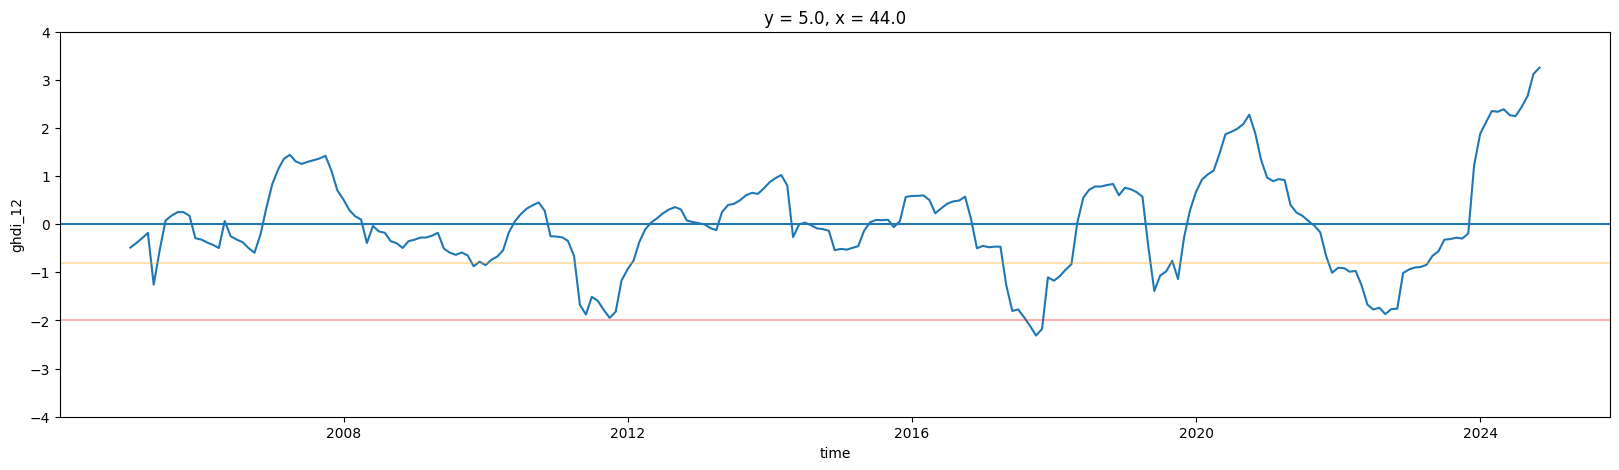

In [35]:

plt.figure(figsize=(20, 5))
ghdi_360.ghdi_12.sel(y=5, x=44, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.8, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

In [232]:
q_global = [0.02, 0.05, 0.10, 0.20, 0.30] # 2nd, 5th, 10th, 20th, 30th percentiles
global_percentiles = g.quantile(q=q_global, dim=None) # dim=None calculates over all dimensions
print("\nGlobal Percentiles (across all data):\n", global_percentiles)


Global Percentiles (across all data):
 <xarray.DataArray 'ghdi_30_ull' (quantile: 5)> Size: 40B
array([-1.5811064 , -1.31177038, -1.0632409 , -0.74309846, -0.51510361])
Coordinates:
  * quantile  (quantile) float64 40B 0.02 0.05 0.1 0.2 0.3


In [49]:

# Assuming your xarray DataArray is named ghdi (dimensions: time, scale)
# For example: ghdi_1month, ghdi_3month, etc.

def compute_drought_duration(ghdi, threshold=-0.5):
    # Create a boolean mask for drought (1 if in drought, 0 otherwise)
    drought_mask = (ghdi <= threshold)
    
    # Convert to numpy for easier processing
    drought_mask_np = drought_mask.values.astype(int)
    
    # Identify drought events using diff
    diff = np.diff(np.concatenate(([0], drought_mask_np, [0])))
    start = np.where(diff == 1)[0]
    end = np.where(diff == -1)[0]
    
    # Duration of each drought period
    durations = end - start
    
    return durations, len(durations), drought_mask.sum().item()

In [87]:
test_xy = final_one_month.sel(y=5, x=45.72, method='nearest')

In [88]:
# Example for 1-month timescale
durations_1m, n_events_1m, total_drought_months_1m = compute_drought_duration(test_xy)

In [89]:
print('Event:', durations_1m, 'months\n')
print('Event:', n_events_1m, '\n')
print('Event:', total_drought_months_1m, '\n') 

Event: [4 2 4 1 4 3 5 1 5 1 2 4 4 3 4 5 2 1 2 1 1 3 2 1] months

Event: 24 

Event: 65 



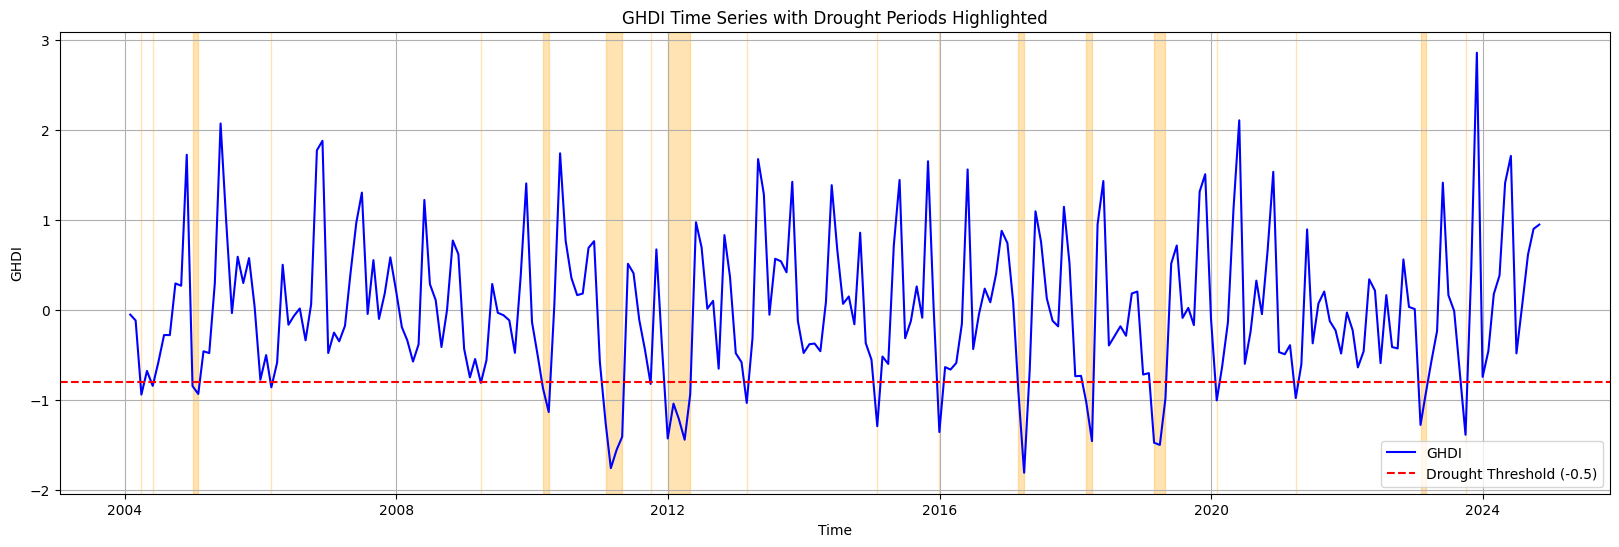

In [90]:
ghdi_mean = test_xy.to_series()

# Set threshold
threshold = -0.8

# Create drought mask
drought_mask = ghdi_mean <= threshold

# Find start and end dates of drought events
diff = np.diff(np.concatenate(([0], drought_mask.astype(int), [0])))
start_idx = np.where(diff == 1)[0]
end_idx = np.where(diff == -1)[0]

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(ghdi_mean.index, ghdi_mean.values, label='GHDI', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Drought Threshold (-0.5)')

# Highlight drought periods
for start, end in zip(start_idx, end_idx):
    plt.axvspan(ghdi_mean.index[start], ghdi_mean.index[end-1], color='orange', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('GHDI')
plt.title('GHDI Time Series with Drought Periods Highlighted')
plt.legend()
plt.grid(True)
plt.show()

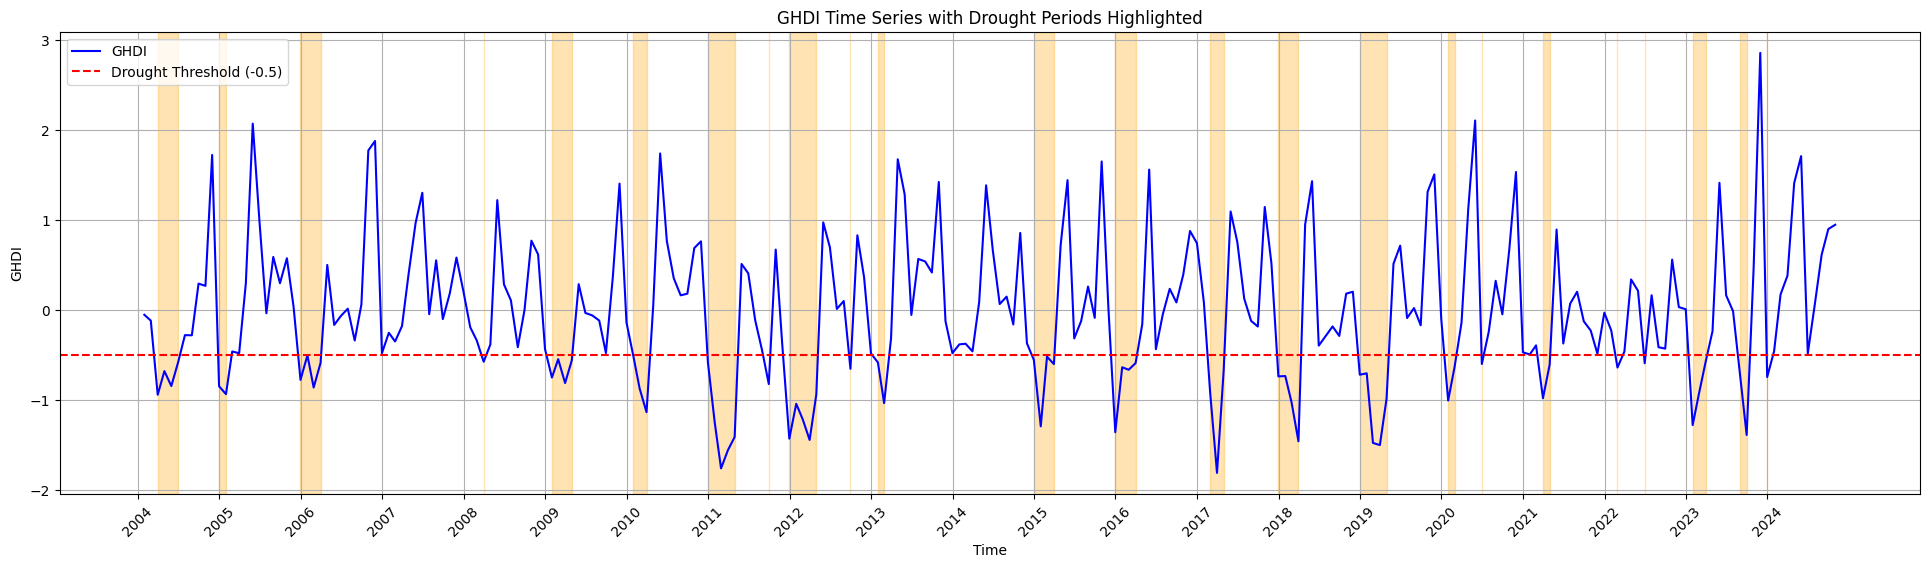

In [91]:
start_year = ghdi_mean.index.min().year
end_year = ghdi_mean.index.max().year

# Generate ticks at the start of each year
xticks = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='YS')

plt.figure(figsize=(24, 6))
plt.plot(ghdi_mean.index, ghdi_mean.values, label='GHDI', color='blue')
plt.axhline(y=-0.5, color='red', linestyle='--', label='Drought Threshold (-0.5)')

# Highlight drought periods
drought_mask = ghdi_mean <= -0.5
diff = np.diff(np.concatenate(([0], drought_mask.astype(int), [0])))
start_idx = np.where(diff == 1)[0]
end_idx = np.where(diff == -1)[0]

for start, end in zip(start_idx, end_idx):
    plt.axvspan(ghdi_mean.index[start], ghdi_mean.index[end-1], color='orange', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('GHDI')
plt.title('GHDI Time Series with Drought Periods Highlighted')
plt.legend()
plt.grid(True)

# Set x-axis ticks
plt.xticks(xticks, [x.year for x in xticks], rotation=45)

plt.show()

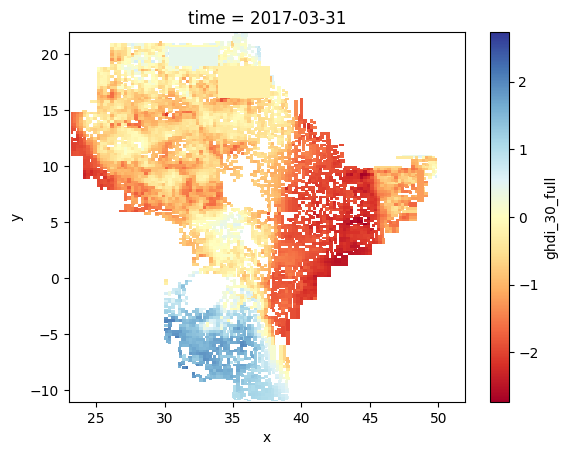

In [113]:
index_clipped = final_one_month.where(~((final_one_month['x'] > 23) & (final_one_month['x'] < 30) & (final_one_month['y'] < -0)))
index_clipped.isel(time=158).plot(cmap='RdYlBu')
# plt.title('Index with Artifact Clipped')
plt.show()

In [4]:
ghdi_w = xr.open_dataset(os.path.join(dir, 'ghdi_full_12m.nc'))
print(ghdi_w)

<xarray.Dataset> Size: 681MB
Dimensions:        (y: 660, x: 540, time: 239)
Coordinates:
  * y              (y) float64 5kB -11.0 -10.95 -10.9 ... 21.85 21.9 21.95
  * x              (x) float64 4kB 23.0 23.05 23.1 23.15 ... 49.85 49.9 49.95
  * time           (time) datetime64[ns] 2kB 2004-12-31 ... 2024-10-31
Data variables:
    ghdi_360_full  (time, y, x) float64 681MB ...


AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

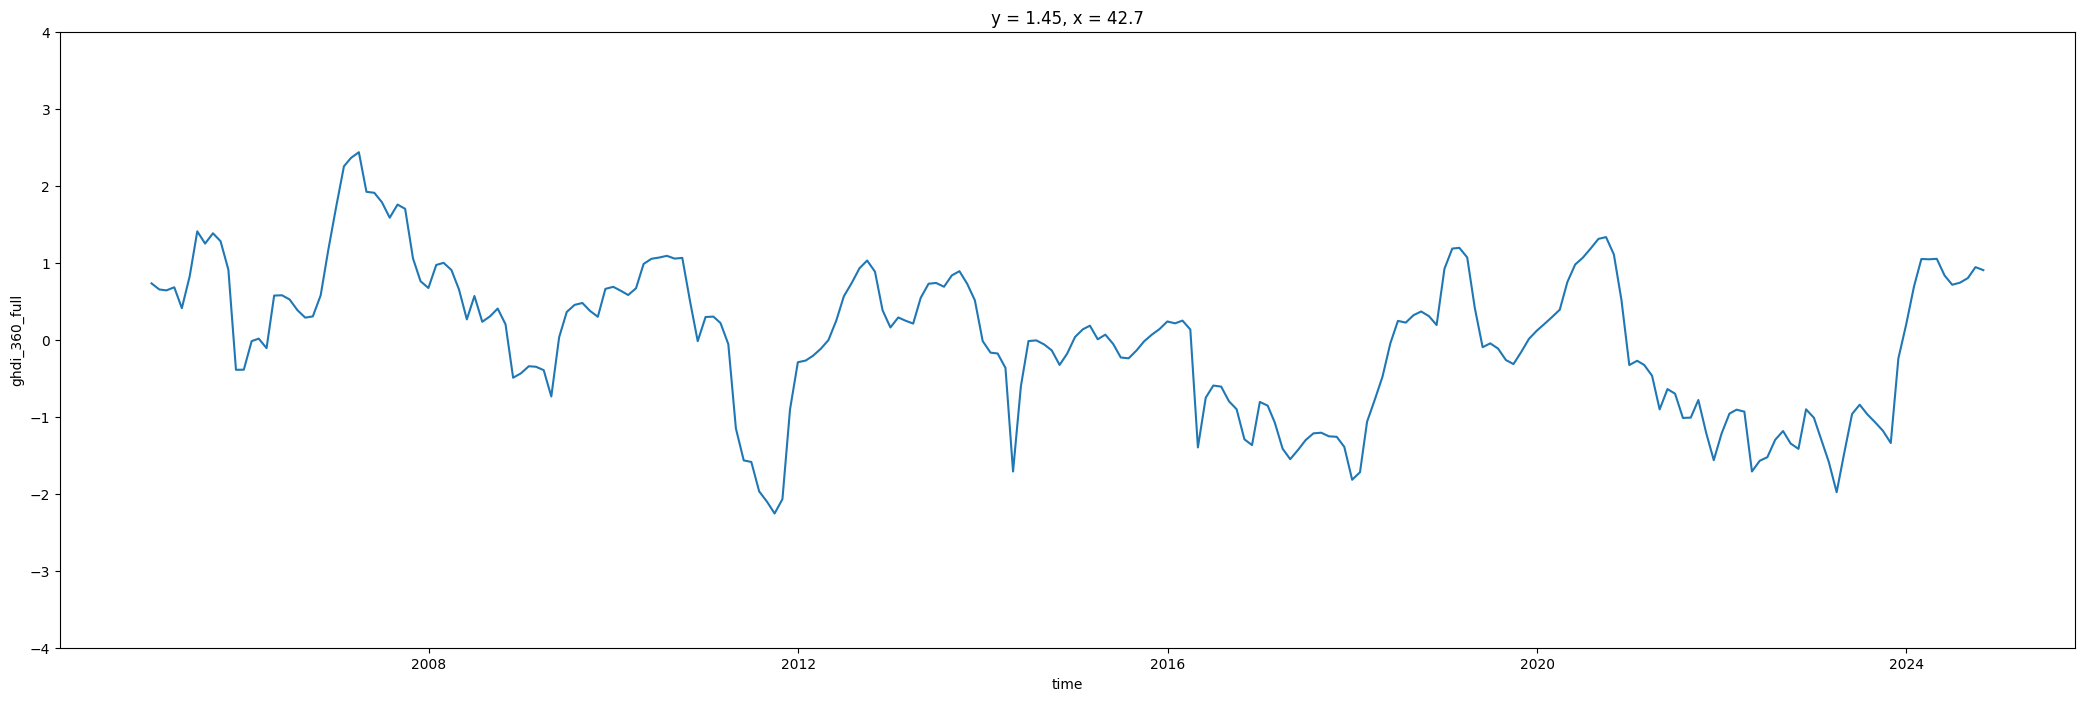

In [7]:
plt.figure(figsize=(26,8))
ghdi_w.ghdi_360_full.sel(y=1.46, x= 42.72, method='nearest').plot(label='GHDI-12')
plt.ylim(-4,4)
plt.label()
plt.grid()